In [1]:
#!git clone https://github.com/darrenyaoyao/HLSFinal.git
!pip3 install -r /content/HLSFinal/requirement.txt
!pip3 install joblib

In [2]:
import os
os.chdir("/content/HLSFinal")

In [3]:
import os
import glob

from PIL import Image, ImageDraw


def get_files(path='./', ext=('.png', '.jpeg', '.jpg')):
    """ Get all image files """
    files = []
    for e in ext:
        files.extend(glob.glob(f'{path}/**/*{e}'))
    files.sort(key=lambda p: (os.path.dirname(p), int(os.path.basename(p).split('.')[0])))
    return files

def to_rgb_and_save(path):
    """ Some of the images may have RGBA mode """
    for p in path:
        img = Image.open(p)
        if img.mode != 'RGB':
            img = img.convert('RGB')
            img.save(p)

ABS_PATH = './'
DATA_PATH = os.path.join(ABS_PATH, 'data')

TRAIN_DIR = os.path.join(DATA_PATH, 'train_images')
TEST_DIR = os.path.join(DATA_PATH, 'test_images')

ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

In [4]:
from collections import Counter


# 1. Get path for TRAIN_DIR/TEST_DIR
trainF, testF = get_files(TRAIN_DIR), get_files(TEST_DIR)

# prepare info for printing
trainC, testC = Counter(map(os.path.dirname, trainF)), Counter(map(os.path.dirname, testF))
train_total, train_text  = sum(trainC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in trainC.items()])
test_total, test_text  = sum(testC.values()), '\n'.join([f'\t- {os.path.basename(fp)} - {c}' for fp, c in testC.items()])

print(f'Train files\n\tpath: {TRAIN_DIR}\n\ttotal number: {train_total}\n{train_text}')
print(f'Train files\n\tpath: {TEST_DIR}\n\ttotal number: {test_total}\n{test_text}')

to_rgb_and_save(trainF), to_rgb_and_save(testF)

Train files
	path: ./data/train_images
	total number: 18
	- adele - 2
	- ariana grande - 2
	- biden - 2
	- curry - 2
	- jay chou - 2
	- jennifer aniston - 2
	- jessica - 2
	- justin bieber - 2
	- trump - 2
Train files
	path: ./data/test_images
	total number: 9
	- adele - 1
	- ariana grande - 1
	- biden - 1
	- curry - 1
	- jay chou - 1
	- jennifer aniston - 1
	- jessica - 1
	- justin bieber - 1
	- trump - 1


(None, None)

In [5]:

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import tqdm
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import shutil
from brevitas.quant_tensor import QuantTensor

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')


def crop_face_and_save(path, new_path=None, model=MTCNN, transformer=None, params=None):
    """
    Detect face on each image, crop them and save to "new_path"
    :param str path: path with images will be passed to  datasets.ImageFolder
    :param str new_path: path to locate new "aligned" images, if new_path is None
                     then new_path will be path + "_cropped"
    :param model: model to detect faces, default MTCNN
    :param transformer: transformer object will be passed to ImageFolder
    :param params: parameters of MTCNN model
    """
    if not new_path:
        new_path = path + '_cropped'

    # in case new_path exists MTCNN model will raise error
    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    # it is default parameters for MTCNN
    if not params:
        params = {
            'image_size': 160, 'margin': 0,
            'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
            'factor': 0.709, 'post_process': False, 'device': device
            }

    model = model(**params)

    if not transformer:
        transformer = transforms.Lambda(
            lambd=lambda x: x.resize((1280, 1280)) if (np.array(x) > 2000).all() else x
        )
    # for convenience we will use ImageFolder instead of getting Image objects by file paths
    dataset = datasets.ImageFolder(path, transform=transformer)
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]

    # batch size 1 as long as we havent exact image size and MTCNN will raise an error
    loader = DataLoader(dataset, batch_size=1, collate_fn=training.collate_pil)
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        model(x, save_path=y)

    # spare some memory
    del model, loader, dataset

# 3. Crop train dataset faces and save aligned images
print('\t- Train data')
crop_face_and_save(TRAIN_DIR, ALIGNED_TRAIN_DIR)

# check if some imgs were missed by detector and failed to save
train_files, train_aligned_files = get_files(TRAIN_DIR), get_files(ALIGNED_TRAIN_DIR)
if len(train_files) != len(train_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TRAIN_DIR), train_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TRAIN_DIR), train_aligned_files))
    detect_failed_train_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

# -------------                     -------------

# Crop test dataset faces and save aligned images
print('\t- Test data')
crop_face_and_save(TEST_DIR, ALIGNED_TEST_DIR)

# check if some imgs were missed by detector and failed to save
test_files, test_aligned_files = get_files(TEST_DIR), get_files(ALIGNED_TEST_DIR)
if len(test_files) != len(test_aligned_files):
    files = set(map(lambda fp: os.path.relpath(fp, start=TEST_DIR), test_files))
    aligned_files = set(map(lambda fp: os.path.relpath(fp, start=ALIGNED_TEST_DIR), test_aligned_files))
    detect_failed_test_files = list(files - aligned_files)
    print(f"\nfiles {len(aligned_files)}/{len(files)}: {', '.join(detect_failed_train_files)} were not saved")

trainF = get_files(ALIGNED_TRAIN_DIR)
testF = get_files(ALIGNED_TEST_DIR)

import albumentations as A

from facenet_pytorch import fixed_image_standardization

standard_transform = transforms.Compose([
                                np.float32,
                                transforms.ToTensor(),
                                fixed_image_standardization
])

aug_mask = A.Compose([
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.15),
                   A.RandomContrast(limit=0.5, p=0.4),
                   A.Rotate(30, p=0.2),
                   A.RandomSizedCrop((120, 120), 160, 160, p=0.4),
                   A.OneOrOther(A.JpegCompression(p=0.2), A.Blur(p=0.2), p=0.66),
                   A.OneOf([
                            A.Rotate(45, p=0.3),
                            A.ElasticTransform(sigma=20, alpha_affine=20, border_mode=0, p=0.2)
                            ], p=0.5),
                  A.HueSaturationValue(val_shift_limit=10, p=0.3)
            ], p=1)

transform = {
    'train': transforms.Compose([
                      transforms.Lambda(lambd=lambda x: aug_mask(image=np.array(x))['image']),
                      standard_transform
                  ]),
    'test': standard_transform
}

from torch.utils.data import SubsetRandomSampler


b = 32

# Original train images
trainD = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=standard_transform)
# Augmented train images
trainD_aug = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
# Train Loader
trainL = DataLoader(trainD, batch_size=b, num_workers=2) # x: torch.Size([batch_size, 3, 160, 160]), y: torch.Size([batch_size])
trainL_aug = DataLoader(trainD_aug, batch_size=b, num_workers=2)

# Original test images
testD = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=standard_transform)
# Test Loader
testL = DataLoader(testD, batch_size=b, num_workers=2)

# Convert encoded labels to named claasses
IDX_TO_CLASS = np.array(list(trainD.class_to_idx.keys()))
CLASS_TO_IDX = dict(trainD.class_to_idx.items())

from model import QuantWeightLeNet
#del model
model = QuantWeightLeNet().to(device)

def fixed_denormalize(image):
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

from random import randrange

criterion = torch.nn.TripletMarginLoss(margin=0.05, p=2).to(device=device)
optimizer = torch.optim.Adam(model.parameters(),
                                lr=1e-5,
                                weight_decay=0.9)

# Training
model
for n_i in tqdm.trange(1000):
    for i, (x, y) in enumerate(trainL, 1):

        x = fixed_denormalize(x)
        anchor_x = x[[0,2,4,6,8,10,12,14,16]]
        anchor_y = y[[0,2,4,6,8,10,12,14,16]]
        positive_x = x[[1,3,5,7,9,11,13,15,17]]
        positive_y = y[[1,3,5,7,9,11,13,15,17]]

        negative_index = [randrange(2,18),
                          randrange(0,2) if randrange(0,2) else randrange(4, 18),
                          randrange(0,4) if randrange(0,2) else randrange(6, 18),
                          randrange(0,6) if randrange(0,2) else randrange(8, 18),
                          randrange(0,8) if randrange(0,2) else randrange(10, 18),
                          randrange(0,10) if randrange(0,2) else randrange(12, 18),
                          randrange(0,12) if randrange(0,2) else randrange(14, 18),
                          randrange(0,14) if randrange(0,2) else randrange(16, 18),
                          randrange(0,16)]

        negative_x = x[negative_index]
        negative_y = y[negative_index]

        anchor_embed = model(anchor_x.to(device))
        positive_embed = model(positive_x.to(device))
        negative_embed = model(negative_x.to(device))

        loss = criterion(anchor_embed, positive_embed, negative_embed)
        print(n_i, ": ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



Running on device: cuda:0
	- Train data


100%|██████████| 18/18 [00:11<00:00,  1.55it/s]


	- Test data


  0%|          | 1/1000 [00:00<13:57,  1.19it/s]

0 :  0.052831146866083145


  0%|          | 2/1000 [00:01<13:06,  1.27it/s]

1 :  0.05183856934309006


  0%|          | 3/1000 [00:02<13:18,  1.25it/s]

2 :  0.06334883719682693


  0%|          | 4/1000 [00:03<13:05,  1.27it/s]

3 :  0.0808139219880104
4 :  0.06054424121975899


  1%|          | 6/1000 [00:05<15:04,  1.10it/s]

5 :  0.048702843487262726
6 :  0.05213715508580208


  1%|          | 8/1000 [00:06<13:02,  1.27it/s]

7 :  0.07812958210706711


  1%|          | 9/1000 [00:07<11:29,  1.44it/s]

8 :  0.035631611943244934


  1%|          | 10/1000 [00:07<10:28,  1.58it/s]

9 :  0.059243135154247284


  1%|          | 11/1000 [00:08<09:47,  1.68it/s]

10 :  0.05850186571478844


  1%|          | 12/1000 [00:08<09:18,  1.77it/s]

11 :  0.04915140941739082


  1%|▏         | 13/1000 [00:09<08:58,  1.83it/s]

12 :  0.054622650146484375


  1%|▏         | 14/1000 [00:09<08:42,  1.89it/s]

13 :  0.02686472050845623


  2%|▏         | 15/1000 [00:10<08:32,  1.92it/s]

14 :  0.040176477283239365


  2%|▏         | 16/1000 [00:10<08:22,  1.96it/s]

15 :  0.023477420210838318


  2%|▏         | 17/1000 [00:11<08:23,  1.95it/s]

16 :  0.050172727555036545


  2%|▏         | 18/1000 [00:11<08:24,  1.95it/s]

17 :  0.028767654672265053


  2%|▏         | 19/1000 [00:12<08:20,  1.96it/s]

18 :  0.041926365345716476


  2%|▏         | 20/1000 [00:12<08:23,  1.95it/s]

19 :  0.0297183096408844


  2%|▏         | 21/1000 [00:13<08:25,  1.94it/s]

20 :  0.032596293836832047


  2%|▏         | 22/1000 [00:13<08:24,  1.94it/s]

21 :  0.03702288120985031


  2%|▏         | 23/1000 [00:14<08:19,  1.96it/s]

22 :  0.053597088903188705


  2%|▏         | 24/1000 [00:14<08:20,  1.95it/s]

23 :  0.0624353364109993


  2%|▎         | 25/1000 [00:15<08:20,  1.95it/s]

24 :  0.03953280672430992


  3%|▎         | 26/1000 [00:15<08:15,  1.96it/s]

25 :  0.031504347920417786


  3%|▎         | 27/1000 [00:16<08:19,  1.95it/s]

26 :  0.049551885575056076


  3%|▎         | 28/1000 [00:16<08:18,  1.95it/s]

27 :  0.08320936560630798


  3%|▎         | 29/1000 [00:17<08:17,  1.95it/s]

28 :  0.03476424887776375


  3%|▎         | 30/1000 [00:17<08:23,  1.93it/s]

29 :  0.06596719473600388


  3%|▎         | 31/1000 [00:18<08:18,  1.94it/s]

30 :  0.0653144121170044


  3%|▎         | 32/1000 [00:18<08:19,  1.94it/s]

31 :  0.04538387060165405


  3%|▎         | 33/1000 [00:19<08:19,  1.94it/s]

32 :  0.027230609208345413


  3%|▎         | 34/1000 [00:19<08:19,  1.93it/s]

33 :  0.025487519800662994


  4%|▎         | 35/1000 [00:20<08:21,  1.92it/s]

34 :  0.02148488536477089


  4%|▎         | 36/1000 [00:20<08:24,  1.91it/s]

35 :  0.037120018154382706


  4%|▎         | 37/1000 [00:21<08:22,  1.92it/s]

36 :  0.039520423859357834


  4%|▍         | 38/1000 [00:21<08:18,  1.93it/s]

37 :  0.034273941069841385


  4%|▍         | 39/1000 [00:22<08:16,  1.94it/s]

38 :  0.047136399894952774


  4%|▍         | 40/1000 [00:22<08:13,  1.95it/s]

39 :  0.045030493289232254


  4%|▍         | 41/1000 [00:23<08:11,  1.95it/s]

40 :  0.04012710228562355


  4%|▍         | 42/1000 [00:23<08:06,  1.97it/s]

41 :  0.03693385422229767


  4%|▍         | 43/1000 [00:24<08:05,  1.97it/s]

42 :  0.046106208115816116


  4%|▍         | 44/1000 [00:24<08:01,  1.99it/s]

43 :  0.04797687008976936


  4%|▍         | 45/1000 [00:25<07:59,  1.99it/s]

44 :  0.03359275311231613


  5%|▍         | 46/1000 [00:25<08:04,  1.97it/s]

45 :  0.03286098688840866


  5%|▍         | 47/1000 [00:26<08:01,  1.98it/s]

46 :  0.04928608238697052


  5%|▍         | 48/1000 [00:26<08:01,  1.98it/s]

47 :  0.05447249859571457


  5%|▍         | 49/1000 [00:27<07:58,  1.99it/s]

48 :  0.05236419290304184


  5%|▌         | 50/1000 [00:27<07:59,  1.98it/s]

49 :  0.0464719794690609


  5%|▌         | 51/1000 [00:28<08:00,  1.98it/s]

50 :  0.0397971086204052


  5%|▌         | 52/1000 [00:28<08:04,  1.96it/s]

51 :  0.030262887477874756


  5%|▌         | 53/1000 [00:29<08:04,  1.95it/s]

52 :  0.025153372436761856


  5%|▌         | 54/1000 [00:29<08:02,  1.96it/s]

53 :  0.03754734992980957


  6%|▌         | 55/1000 [00:30<08:01,  1.96it/s]

54 :  0.034039195626974106


  6%|▌         | 56/1000 [00:30<08:02,  1.96it/s]

55 :  0.05753004550933838


  6%|▌         | 57/1000 [00:31<08:03,  1.95it/s]

56 :  0.035253193229436874


  6%|▌         | 58/1000 [00:32<08:02,  1.95it/s]

57 :  0.01455507893115282


  6%|▌         | 59/1000 [00:32<08:02,  1.95it/s]

58 :  0.05240112543106079


  6%|▌         | 60/1000 [00:33<08:05,  1.93it/s]

59 :  0.04076765477657318


  6%|▌         | 61/1000 [00:33<08:06,  1.93it/s]

60 :  0.025275489315390587


  6%|▌         | 62/1000 [00:34<08:02,  1.94it/s]

61 :  0.04574976861476898


  6%|▋         | 63/1000 [00:34<08:05,  1.93it/s]

62 :  0.044636111706495285


  6%|▋         | 64/1000 [00:35<07:59,  1.95it/s]

63 :  0.06349753588438034


  6%|▋         | 65/1000 [00:35<07:59,  1.95it/s]

64 :  0.05508189648389816


  7%|▋         | 66/1000 [00:36<08:00,  1.94it/s]

65 :  0.0364433191716671


  7%|▋         | 67/1000 [00:36<07:55,  1.96it/s]

66 :  0.06303229928016663


  7%|▋         | 68/1000 [00:37<07:55,  1.96it/s]

67 :  0.06311046332120895


  7%|▋         | 69/1000 [00:37<07:48,  1.99it/s]

68 :  0.037614721804857254


  7%|▋         | 70/1000 [00:38<07:53,  1.97it/s]

69 :  0.039423491805791855


  7%|▋         | 71/1000 [00:38<07:50,  1.97it/s]

70 :  0.03361031040549278


  7%|▋         | 72/1000 [00:39<07:54,  1.96it/s]

71 :  0.02716277353465557


  7%|▋         | 73/1000 [00:39<07:49,  1.97it/s]

72 :  0.033047281205654144


  7%|▋         | 74/1000 [00:40<07:47,  1.98it/s]

73 :  0.025669438764452934


  8%|▊         | 75/1000 [00:40<07:47,  1.98it/s]

74 :  0.0407005175948143


  8%|▊         | 76/1000 [00:41<07:45,  1.98it/s]

75 :  0.04147776588797569


  8%|▊         | 77/1000 [00:41<07:44,  1.99it/s]

76 :  0.06038007512688637


  8%|▊         | 78/1000 [00:42<07:49,  1.96it/s]

77 :  0.046974241733551025


  8%|▊         | 79/1000 [00:42<07:46,  1.98it/s]

78 :  0.039580147713422775


  8%|▊         | 80/1000 [00:43<07:47,  1.97it/s]

79 :  0.04994577914476395


  8%|▊         | 81/1000 [00:43<07:47,  1.96it/s]

80 :  0.03736303374171257


  8%|▊         | 82/1000 [00:44<07:49,  1.95it/s]

81 :  0.022045470774173737


  8%|▊         | 83/1000 [00:44<07:49,  1.95it/s]

82 :  0.048214979469776154


  8%|▊         | 84/1000 [00:45<07:50,  1.95it/s]

83 :  0.045002538710832596


  8%|▊         | 85/1000 [00:45<07:46,  1.96it/s]

84 :  0.03390032798051834


  9%|▊         | 86/1000 [00:46<07:47,  1.96it/s]

85 :  0.04446263983845711


  9%|▊         | 87/1000 [00:46<07:49,  1.95it/s]

86 :  0.06214441731572151


  9%|▉         | 88/1000 [00:47<07:45,  1.96it/s]

87 :  0.040865231305360794


  9%|▉         | 89/1000 [00:47<07:45,  1.96it/s]

88 :  0.0665583536028862


  9%|▉         | 90/1000 [00:48<07:45,  1.95it/s]

89 :  0.03853248804807663


  9%|▉         | 91/1000 [00:48<07:41,  1.97it/s]

90 :  0.01832219585776329


  9%|▉         | 92/1000 [00:49<07:43,  1.96it/s]

91 :  0.029390135779976845


  9%|▉         | 93/1000 [00:49<07:43,  1.96it/s]

92 :  0.031182553619146347


  9%|▉         | 94/1000 [00:50<07:43,  1.95it/s]

93 :  0.05305716022849083


 10%|▉         | 95/1000 [00:50<07:38,  1.98it/s]

94 :  0.05346699431538582


 10%|▉         | 96/1000 [00:51<07:43,  1.95it/s]

95 :  0.03485138714313507


 10%|▉         | 97/1000 [00:51<07:47,  1.93it/s]

96 :  0.04253580793738365


 10%|▉         | 98/1000 [00:52<08:02,  1.87it/s]

97 :  0.03267185762524605


 10%|▉         | 99/1000 [00:53<09:07,  1.65it/s]

98 :  0.05379479005932808


 10%|█         | 100/1000 [00:54<10:04,  1.49it/s]

99 :  0.042577095329761505


 10%|█         | 101/1000 [00:54<10:14,  1.46it/s]

100 :  0.03923267498612404


 10%|█         | 102/1000 [00:55<10:27,  1.43it/s]

101 :  0.03157463297247887
102 :  0.025738678872585297


 10%|█         | 103/1000 [00:56<10:52,  1.38it/s]

103 :  0.044853031635284424


 10%|█         | 104/1000 [00:57<10:56,  1.37it/s]

104 :  0.030855033546686172


 11%|█         | 106/1000 [00:58<10:28,  1.42it/s]

105 :  0.0469227097928524


 11%|█         | 107/1000 [00:59<10:26,  1.42it/s]

106 :  0.039334602653980255


 11%|█         | 108/1000 [00:59<08:53,  1.67it/s]

107 :  0.05040357634425163


 11%|█         | 109/1000 [00:59<07:49,  1.90it/s]

108 :  0.022286279127001762


 11%|█         | 110/1000 [01:00<07:03,  2.10it/s]

109 :  0.04404966160655022


 11%|█         | 111/1000 [01:00<06:32,  2.27it/s]

110 :  0.0489981584250927


 11%|█         | 112/1000 [01:00<06:09,  2.41it/s]

111 :  0.048788655549287796


 11%|█▏        | 113/1000 [01:01<05:52,  2.52it/s]

112 :  0.046282555907964706


 11%|█▏        | 114/1000 [01:01<05:39,  2.61it/s]

113 :  0.0475054569542408


 12%|█▏        | 115/1000 [01:02<05:34,  2.64it/s]

114 :  0.06201593205332756


 12%|█▏        | 116/1000 [01:02<05:25,  2.71it/s]

115 :  0.03075476549565792


 12%|█▏        | 117/1000 [01:02<05:23,  2.73it/s]

116 :  0.026893343776464462


 12%|█▏        | 118/1000 [01:03<05:20,  2.75it/s]

117 :  0.02076297625899315


 12%|█▏        | 119/1000 [01:03<05:23,  2.73it/s]

118 :  0.04680110514163971


 12%|█▏        | 120/1000 [01:03<05:20,  2.75it/s]

119 :  0.04558660462498665


 12%|█▏        | 121/1000 [01:04<05:20,  2.75it/s]

120 :  0.03167449310421944


 12%|█▏        | 122/1000 [01:04<05:14,  2.79it/s]

121 :  0.03755927458405495


 12%|█▏        | 123/1000 [01:04<05:15,  2.78it/s]

122 :  0.05431389808654785


 12%|█▏        | 124/1000 [01:05<05:12,  2.80it/s]

123 :  0.04641054943203926


 12%|█▎        | 125/1000 [01:05<05:13,  2.79it/s]

124 :  0.0670831948518753


 13%|█▎        | 126/1000 [01:05<05:13,  2.79it/s]

125 :  0.0539250373840332


 13%|█▎        | 127/1000 [01:06<05:14,  2.78it/s]

126 :  0.041719306260347366


 13%|█▎        | 128/1000 [01:06<05:10,  2.81it/s]

127 :  0.04126056656241417


 13%|█▎        | 129/1000 [01:07<05:14,  2.77it/s]

128 :  0.046649616211652756


 13%|█▎        | 130/1000 [01:07<05:13,  2.77it/s]

129 :  0.02930067665874958


 13%|█▎        | 131/1000 [01:07<05:12,  2.78it/s]

130 :  0.02609775960445404


 13%|█▎        | 132/1000 [01:08<05:10,  2.79it/s]

131 :  0.05650903657078743


 13%|█▎        | 133/1000 [01:08<05:07,  2.82it/s]

132 :  0.05542047694325447


 13%|█▎        | 134/1000 [01:08<05:05,  2.84it/s]

133 :  0.03591113165020943


 14%|█▎        | 135/1000 [01:09<05:09,  2.80it/s]

134 :  0.032584019005298615


 14%|█▎        | 136/1000 [01:09<05:06,  2.82it/s]

135 :  0.03591948002576828


 14%|█▎        | 137/1000 [01:09<05:04,  2.83it/s]

136 :  0.023736657574772835


 14%|█▍        | 138/1000 [01:10<05:05,  2.82it/s]

137 :  0.024875737726688385


 14%|█▍        | 139/1000 [01:10<05:03,  2.84it/s]

138 :  0.029876159504055977


 14%|█▍        | 140/1000 [01:10<05:01,  2.85it/s]

139 :  0.057396870106458664


 14%|█▍        | 141/1000 [01:11<05:05,  2.81it/s]

140 :  0.030911577865481377


 14%|█▍        | 142/1000 [01:11<05:07,  2.79it/s]

141 :  0.026910873129963875


 14%|█▍        | 143/1000 [01:12<05:06,  2.79it/s]

142 :  0.035876572132110596


 14%|█▍        | 144/1000 [01:12<05:12,  2.74it/s]

143 :  0.05479734018445015


 14%|█▍        | 145/1000 [01:12<05:08,  2.77it/s]

144 :  0.04245362803339958


 15%|█▍        | 146/1000 [01:13<05:04,  2.81it/s]

145 :  0.050404224544763565


 15%|█▍        | 147/1000 [01:13<05:04,  2.80it/s]

146 :  0.06098836660385132


 15%|█▍        | 148/1000 [01:13<05:05,  2.79it/s]

147 :  0.02157747745513916


 15%|█▍        | 149/1000 [01:14<05:03,  2.80it/s]

148 :  0.07117896527051926


 15%|█▌        | 150/1000 [01:14<05:05,  2.78it/s]

149 :  0.033777132630348206


 15%|█▌        | 151/1000 [01:14<05:01,  2.82it/s]

150 :  0.06272187829017639


 15%|█▌        | 152/1000 [01:15<05:03,  2.80it/s]

151 :  0.02956884726881981


 15%|█▌        | 153/1000 [01:15<05:01,  2.81it/s]

152 :  0.0462491512298584


 15%|█▌        | 154/1000 [01:15<05:01,  2.80it/s]

153 :  0.01396703440696001


 16%|█▌        | 155/1000 [01:16<04:58,  2.83it/s]

154 :  0.028293080627918243


 16%|█▌        | 156/1000 [01:16<04:56,  2.85it/s]

155 :  0.026445753872394562


 16%|█▌        | 157/1000 [01:17<04:55,  2.85it/s]

156 :  0.03301556780934334


 16%|█▌        | 158/1000 [01:17<04:57,  2.83it/s]

157 :  0.01911814697086811


 16%|█▌        | 159/1000 [01:17<04:55,  2.85it/s]

158 :  0.040291957557201385


 16%|█▌        | 160/1000 [01:18<04:54,  2.85it/s]

159 :  0.04244687780737877


 16%|█▌        | 161/1000 [01:18<04:54,  2.85it/s]

160 :  0.048813290894031525


 16%|█▌        | 162/1000 [01:18<04:55,  2.84it/s]

161 :  0.03861613944172859


 16%|█▋        | 163/1000 [01:19<04:52,  2.86it/s]

162 :  0.03944752737879753


 16%|█▋        | 164/1000 [01:19<04:52,  2.86it/s]

163 :  0.03933461382985115


 16%|█▋        | 165/1000 [01:19<04:49,  2.88it/s]

164 :  0.034773699939250946


 17%|█▋        | 166/1000 [01:20<04:51,  2.86it/s]

165 :  0.038947928696870804


 17%|█▋        | 167/1000 [01:20<04:50,  2.87it/s]

166 :  0.018739836290478706


 17%|█▋        | 168/1000 [01:20<04:50,  2.87it/s]

167 :  0.02978299744427204


 17%|█▋        | 169/1000 [01:21<04:50,  2.86it/s]

168 :  0.019590169191360474


 17%|█▋        | 170/1000 [01:21<04:51,  2.84it/s]

169 :  0.033858682960271835


 17%|█▋        | 171/1000 [01:21<04:53,  2.83it/s]

170 :  0.028930868953466415


 17%|█▋        | 172/1000 [01:22<04:50,  2.85it/s]

171 :  0.031729940325021744


 17%|█▋        | 173/1000 [01:22<04:49,  2.86it/s]

172 :  0.02444359101355076


 17%|█▋        | 174/1000 [01:22<04:49,  2.86it/s]

173 :  0.03774850443005562


 18%|█▊        | 175/1000 [01:23<04:49,  2.85it/s]

174 :  0.03652096912264824


 18%|█▊        | 176/1000 [01:23<04:46,  2.87it/s]

175 :  0.03708035498857498


 18%|█▊        | 177/1000 [01:24<04:47,  2.86it/s]

176 :  0.04747762158513069


 18%|█▊        | 178/1000 [01:24<04:50,  2.83it/s]

177 :  0.043944794684648514


 18%|█▊        | 179/1000 [01:24<04:50,  2.83it/s]

178 :  0.039577048271894455


 18%|█▊        | 180/1000 [01:25<04:51,  2.82it/s]

179 :  0.046856530010700226


 18%|█▊        | 181/1000 [01:25<04:47,  2.85it/s]

180 :  0.040286917239427567


 18%|█▊        | 182/1000 [01:25<04:50,  2.81it/s]

181 :  0.043746139854192734


 18%|█▊        | 183/1000 [01:26<04:45,  2.87it/s]

182 :  0.038207050412893295


 18%|█▊        | 184/1000 [01:26<04:44,  2.87it/s]

183 :  0.030836423859000206


 18%|█▊        | 185/1000 [01:26<04:47,  2.83it/s]

184 :  0.04289286956191063


 19%|█▊        | 186/1000 [01:27<04:43,  2.87it/s]

185 :  0.057329270988702774


 19%|█▊        | 187/1000 [01:27<04:42,  2.88it/s]

186 :  0.04038920998573303


 19%|█▉        | 188/1000 [01:27<04:46,  2.84it/s]

187 :  0.030360082164406776


 19%|█▉        | 189/1000 [01:28<04:47,  2.82it/s]

188 :  0.03936585411429405


 19%|█▉        | 190/1000 [01:28<04:47,  2.82it/s]

189 :  0.043694425374269485


 19%|█▉        | 191/1000 [01:28<04:50,  2.79it/s]

190 :  0.02494623325765133


 19%|█▉        | 192/1000 [01:29<04:48,  2.80it/s]

191 :  0.05308547616004944


 19%|█▉        | 193/1000 [01:29<04:45,  2.83it/s]

192 :  0.019024141132831573


 19%|█▉        | 194/1000 [01:30<04:47,  2.81it/s]

193 :  0.042732980102300644


 20%|█▉        | 195/1000 [01:30<04:47,  2.80it/s]

194 :  0.0378076434135437


 20%|█▉        | 196/1000 [01:30<04:52,  2.75it/s]

195 :  0.04993065074086189


 20%|█▉        | 197/1000 [01:31<04:49,  2.78it/s]

196 :  0.05214449763298035


 20%|█▉        | 198/1000 [01:31<04:47,  2.79it/s]

197 :  0.05008627101778984


 20%|█▉        | 199/1000 [01:31<04:47,  2.78it/s]

198 :  0.045788101851940155


 20%|██        | 200/1000 [01:32<04:48,  2.78it/s]

199 :  0.04638742282986641


 20%|██        | 201/1000 [01:32<04:44,  2.80it/s]

200 :  0.026260629296302795


 20%|██        | 202/1000 [01:32<04:46,  2.78it/s]

201 :  0.045839905738830566


 20%|██        | 203/1000 [01:33<04:47,  2.78it/s]

202 :  0.04238135367631912


 20%|██        | 204/1000 [01:33<04:47,  2.77it/s]

203 :  0.042937278747558594


 20%|██        | 205/1000 [01:33<04:46,  2.77it/s]

204 :  0.03637608140707016


 21%|██        | 206/1000 [01:34<04:46,  2.77it/s]

205 :  0.038720592856407166


 21%|██        | 207/1000 [01:34<04:47,  2.76it/s]

206 :  0.05307314917445183


 21%|██        | 208/1000 [01:35<04:51,  2.72it/s]

207 :  0.03957429528236389


 21%|██        | 209/1000 [01:35<04:46,  2.76it/s]

208 :  0.019480431452393532


 21%|██        | 210/1000 [01:35<04:44,  2.78it/s]

209 :  0.04716278240084648


 21%|██        | 211/1000 [01:36<04:50,  2.72it/s]

210 :  0.05333739519119263


 21%|██        | 212/1000 [01:36<04:47,  2.74it/s]

211 :  0.0559709407389164


 21%|██▏       | 213/1000 [01:36<04:49,  2.72it/s]

212 :  0.03605257719755173


 21%|██▏       | 214/1000 [01:37<04:46,  2.75it/s]

213 :  0.022358493879437447


 22%|██▏       | 215/1000 [01:37<04:44,  2.76it/s]

214 :  0.015524272806942463


 22%|██▏       | 216/1000 [01:38<04:45,  2.75it/s]

215 :  0.05152987316250801


 22%|██▏       | 217/1000 [01:38<04:47,  2.72it/s]

216 :  0.053926754742860794


 22%|██▏       | 218/1000 [01:38<04:45,  2.74it/s]

217 :  0.049190450459718704


 22%|██▏       | 219/1000 [01:39<04:46,  2.72it/s]

218 :  0.035560544580221176


 22%|██▏       | 220/1000 [01:39<04:42,  2.76it/s]

219 :  0.021247146651148796


 22%|██▏       | 221/1000 [01:39<04:39,  2.78it/s]

220 :  0.048398833721876144


 22%|██▏       | 222/1000 [01:40<04:40,  2.78it/s]

221 :  0.04867960885167122


 22%|██▏       | 223/1000 [01:40<04:37,  2.80it/s]

222 :  0.03675366938114166


 22%|██▏       | 224/1000 [01:40<04:37,  2.79it/s]

223 :  0.05042966827750206


 22%|██▎       | 225/1000 [01:41<04:39,  2.77it/s]

224 :  0.043564654886722565


 23%|██▎       | 226/1000 [01:41<04:37,  2.79it/s]

225 :  0.014569795690476894


 23%|██▎       | 227/1000 [01:41<04:36,  2.79it/s]

226 :  0.047388527542352676


 23%|██▎       | 228/1000 [01:42<04:38,  2.78it/s]

227 :  0.05212396755814552


 23%|██▎       | 229/1000 [01:42<04:35,  2.79it/s]

228 :  0.041699692606925964


 23%|██▎       | 230/1000 [01:43<04:33,  2.81it/s]

229 :  0.039332181215286255


 23%|██▎       | 231/1000 [01:43<04:45,  2.70it/s]

230 :  0.02600971981883049


 23%|██▎       | 232/1000 [01:44<07:15,  1.76it/s]

231 :  0.06035785749554634


 23%|██▎       | 233/1000 [01:44<06:24,  1.99it/s]

232 :  0.05599840357899666
233 :  0.0546753890812397


 24%|██▎       | 235/1000 [01:46<07:22,  1.73it/s]

234 :  0.04974145069718361
235 :  0.06407810747623444


 24%|██▎       | 237/1000 [01:47<07:49,  1.63it/s]

236 :  0.05138789862394333


 24%|██▍       | 238/1000 [01:48<06:50,  1.86it/s]

237 :  0.036121293902397156


 24%|██▍       | 239/1000 [01:48<06:09,  2.06it/s]

238 :  0.05490114167332649


 24%|██▍       | 240/1000 [01:48<05:38,  2.24it/s]

239 :  0.017791548743844032


 24%|██▍       | 241/1000 [01:49<05:14,  2.41it/s]

240 :  0.03570660576224327


 24%|██▍       | 242/1000 [01:49<05:03,  2.50it/s]

241 :  0.03783513605594635


 24%|██▍       | 243/1000 [01:49<04:51,  2.60it/s]

242 :  0.052605945616960526


 24%|██▍       | 244/1000 [01:50<04:45,  2.65it/s]

243 :  0.03580155596137047


 24%|██▍       | 245/1000 [01:50<04:38,  2.71it/s]

244 :  0.04739943519234657


 25%|██▍       | 246/1000 [01:50<04:34,  2.74it/s]

245 :  0.061946697533130646


 25%|██▍       | 247/1000 [01:51<04:32,  2.76it/s]

246 :  0.03605717420578003


 25%|██▍       | 248/1000 [01:51<04:32,  2.75it/s]

247 :  0.04761010780930519


 25%|██▍       | 249/1000 [01:51<04:28,  2.80it/s]

248 :  0.038679108023643494


 25%|██▌       | 250/1000 [01:52<04:26,  2.81it/s]

249 :  0.0361611545085907


 25%|██▌       | 251/1000 [01:52<04:29,  2.78it/s]

250 :  0.04751467704772949


 25%|██▌       | 252/1000 [01:53<04:28,  2.79it/s]

251 :  0.034026581794023514


 25%|██▌       | 253/1000 [01:53<04:27,  2.79it/s]

252 :  0.04875418171286583


 25%|██▌       | 254/1000 [01:53<04:30,  2.75it/s]

253 :  0.04017508029937744


 26%|██▌       | 255/1000 [01:54<04:29,  2.77it/s]

254 :  0.05127175152301788


 26%|██▌       | 256/1000 [01:54<04:27,  2.78it/s]

255 :  0.05239183455705643


 26%|██▌       | 257/1000 [01:54<04:28,  2.76it/s]

256 :  0.028803259134292603


 26%|██▌       | 258/1000 [01:55<04:29,  2.76it/s]

257 :  0.027676399797201157


 26%|██▌       | 259/1000 [01:55<04:31,  2.73it/s]

258 :  0.045400138944387436


 26%|██▌       | 260/1000 [01:55<04:30,  2.73it/s]

259 :  0.0247978325933218


 26%|██▌       | 261/1000 [01:56<04:32,  2.71it/s]

260 :  0.024159152060747147


 26%|██▌       | 262/1000 [01:56<04:27,  2.76it/s]

261 :  0.079518623650074


 26%|██▋       | 263/1000 [01:57<04:25,  2.77it/s]

262 :  0.045550908893346786


 26%|██▋       | 264/1000 [01:57<04:26,  2.76it/s]

263 :  0.04554968327283859


 26%|██▋       | 265/1000 [01:57<04:27,  2.74it/s]

264 :  0.03499770537018776


 27%|██▋       | 266/1000 [01:58<04:29,  2.73it/s]

265 :  0.051062941551208496


 27%|██▋       | 267/1000 [01:58<04:26,  2.75it/s]

266 :  0.04354320093989372


 27%|██▋       | 268/1000 [01:58<04:27,  2.74it/s]

267 :  0.04328525438904762


 27%|██▋       | 269/1000 [01:59<04:29,  2.71it/s]

268 :  0.034072395414114


 27%|██▋       | 270/1000 [01:59<04:25,  2.75it/s]

269 :  0.04223779961466789


 27%|██▋       | 271/1000 [01:59<04:26,  2.73it/s]

270 :  0.045987021178007126


 27%|██▋       | 272/1000 [02:00<04:26,  2.74it/s]

271 :  0.04795336350798607


 27%|██▋       | 273/1000 [02:00<04:25,  2.73it/s]

272 :  0.030793363228440285


 27%|██▋       | 274/1000 [02:01<04:18,  2.81it/s]

273 :  0.03029756434261799


 28%|██▊       | 275/1000 [02:01<04:15,  2.83it/s]

274 :  0.05965614318847656


 28%|██▊       | 276/1000 [02:01<04:16,  2.82it/s]

275 :  0.05196104571223259


 28%|██▊       | 277/1000 [02:02<04:13,  2.85it/s]

276 :  0.0401831679046154


 28%|██▊       | 278/1000 [02:02<04:13,  2.85it/s]

277 :  0.037739794701337814


 28%|██▊       | 279/1000 [02:02<04:14,  2.83it/s]

278 :  0.045668862760066986


 28%|██▊       | 280/1000 [02:03<04:16,  2.81it/s]

279 :  0.049262482672929764


 28%|██▊       | 281/1000 [02:03<04:16,  2.81it/s]

280 :  0.05810781195759773


 28%|██▊       | 282/1000 [02:03<04:20,  2.75it/s]

281 :  0.04837695136666298


 28%|██▊       | 283/1000 [02:04<04:19,  2.77it/s]

282 :  0.04130829870700836


 28%|██▊       | 284/1000 [02:04<04:18,  2.77it/s]

283 :  0.052744366228580475


 28%|██▊       | 285/1000 [02:04<04:19,  2.75it/s]

284 :  0.04140501096844673


 29%|██▊       | 286/1000 [02:05<04:19,  2.75it/s]

285 :  0.02749764546751976


 29%|██▊       | 287/1000 [02:05<04:18,  2.76it/s]

286 :  0.03627047315239906


 29%|██▉       | 288/1000 [02:06<04:17,  2.76it/s]

287 :  0.03103315457701683


 29%|██▉       | 289/1000 [02:06<04:14,  2.80it/s]

288 :  0.042516887187957764


 29%|██▉       | 290/1000 [02:06<04:16,  2.76it/s]

289 :  0.04119505360722542


 29%|██▉       | 291/1000 [02:07<04:18,  2.74it/s]

290 :  0.04395950213074684


 29%|██▉       | 292/1000 [02:07<04:17,  2.75it/s]

291 :  0.025560816749930382


 29%|██▉       | 293/1000 [02:07<04:19,  2.72it/s]

292 :  0.01323202345520258


 29%|██▉       | 294/1000 [02:08<04:17,  2.74it/s]

293 :  0.05692266672849655


 30%|██▉       | 295/1000 [02:08<04:14,  2.77it/s]

294 :  0.05758575722575188


 30%|██▉       | 296/1000 [02:08<04:14,  2.77it/s]

295 :  0.03747740387916565


 30%|██▉       | 297/1000 [02:09<04:12,  2.78it/s]

296 :  0.04654170572757721


 30%|██▉       | 298/1000 [02:09<04:11,  2.79it/s]

297 :  0.03004361502826214


 30%|██▉       | 299/1000 [02:10<04:16,  2.73it/s]

298 :  0.061009302735328674


 30%|███       | 300/1000 [02:10<04:16,  2.73it/s]

299 :  0.04035478085279465


 30%|███       | 301/1000 [02:10<04:14,  2.75it/s]

300 :  0.054880719631910324


 30%|███       | 302/1000 [02:11<04:15,  2.73it/s]

301 :  0.06398151814937592


 30%|███       | 303/1000 [02:11<04:12,  2.76it/s]

302 :  0.0500047467648983


 30%|███       | 304/1000 [02:11<04:11,  2.76it/s]

303 :  0.06330322474241257


 30%|███       | 305/1000 [02:12<04:11,  2.76it/s]

304 :  0.04703129827976227


 31%|███       | 306/1000 [02:12<04:09,  2.78it/s]

305 :  0.04089544713497162


 31%|███       | 307/1000 [02:12<04:07,  2.80it/s]

306 :  0.056433334946632385


 31%|███       | 308/1000 [02:13<04:09,  2.77it/s]

307 :  0.04710745811462402


 31%|███       | 309/1000 [02:13<04:09,  2.77it/s]

308 :  0.06583187729120255


 31%|███       | 310/1000 [02:14<04:10,  2.76it/s]

309 :  0.05619906261563301


 31%|███       | 311/1000 [02:14<04:11,  2.74it/s]

310 :  0.059472933411598206


 31%|███       | 312/1000 [02:14<04:08,  2.77it/s]

311 :  0.07162985950708389


 31%|███▏      | 313/1000 [02:15<04:09,  2.76it/s]

312 :  0.07725540548563004


 31%|███▏      | 314/1000 [02:15<04:12,  2.72it/s]

313 :  0.06060779094696045


 32%|███▏      | 315/1000 [02:16<04:53,  2.34it/s]

314 :  0.06362152099609375


 32%|███▏      | 316/1000 [02:16<05:03,  2.25it/s]

315 :  0.047429997473955154


 32%|███▏      | 317/1000 [02:16<04:47,  2.38it/s]

316 :  0.058553628623485565


 32%|███▏      | 318/1000 [02:17<04:36,  2.46it/s]

317 :  0.0699392557144165


 32%|███▏      | 319/1000 [02:17<04:28,  2.54it/s]

318 :  0.042766034603118896


 32%|███▏      | 320/1000 [02:17<04:22,  2.59it/s]

319 :  0.04297982528805733


 32%|███▏      | 321/1000 [02:18<04:19,  2.61it/s]

320 :  0.05191568657755852


 32%|███▏      | 322/1000 [02:18<04:13,  2.67it/s]

321 :  0.04594504460692406


 32%|███▏      | 323/1000 [02:19<04:10,  2.70it/s]

322 :  0.04860202968120575


 32%|███▏      | 324/1000 [02:19<04:10,  2.70it/s]

323 :  0.052386797964572906


 32%|███▎      | 325/1000 [02:19<04:07,  2.73it/s]

324 :  0.06322827935218811


 33%|███▎      | 326/1000 [02:20<04:04,  2.76it/s]

325 :  0.02772909216582775


 33%|███▎      | 327/1000 [02:20<04:03,  2.76it/s]

326 :  0.033980295062065125


 33%|███▎      | 328/1000 [02:20<04:04,  2.74it/s]

327 :  0.027972111478447914


 33%|███▎      | 329/1000 [02:21<04:05,  2.73it/s]

328 :  0.046002838760614395


 33%|███▎      | 330/1000 [02:21<04:06,  2.72it/s]

329 :  0.0341842882335186


 33%|███▎      | 331/1000 [02:22<04:04,  2.73it/s]

330 :  0.044157736003398895


 33%|███▎      | 332/1000 [02:22<04:06,  2.71it/s]

331 :  0.05095298960804939


 33%|███▎      | 333/1000 [02:22<04:04,  2.73it/s]

332 :  0.038256652653217316


 33%|███▎      | 334/1000 [02:23<04:05,  2.71it/s]

333 :  0.05539296939969063


 34%|███▎      | 335/1000 [02:23<04:07,  2.68it/s]

334 :  0.04179314151406288


 34%|███▎      | 336/1000 [02:23<04:06,  2.69it/s]

335 :  0.0334702730178833


 34%|███▎      | 337/1000 [02:24<04:06,  2.69it/s]

336 :  0.03676573559641838


 34%|███▍      | 338/1000 [02:24<04:05,  2.70it/s]

337 :  0.047901857644319534


 34%|███▍      | 339/1000 [02:24<04:02,  2.72it/s]

338 :  0.06499617546796799


 34%|███▍      | 340/1000 [02:25<04:01,  2.73it/s]

339 :  0.048005957156419754


 34%|███▍      | 341/1000 [02:25<03:58,  2.76it/s]

340 :  0.04150368645787239


 34%|███▍      | 342/1000 [02:26<03:57,  2.77it/s]

341 :  0.03730516880750656


 34%|███▍      | 343/1000 [02:26<03:58,  2.76it/s]

342 :  0.047291792929172516


 34%|███▍      | 344/1000 [02:26<04:00,  2.73it/s]

343 :  0.042096350342035294


 34%|███▍      | 345/1000 [02:27<04:04,  2.68it/s]

344 :  0.03676049783825874


 35%|███▍      | 346/1000 [02:27<04:03,  2.69it/s]

345 :  0.05273137986660004


 35%|███▍      | 347/1000 [02:27<04:02,  2.69it/s]

346 :  0.0590028315782547


 35%|███▍      | 348/1000 [02:28<04:46,  2.28it/s]

347 :  0.04827043414115906


 35%|███▍      | 349/1000 [02:28<04:32,  2.39it/s]

348 :  0.04135431721806526


 35%|███▌      | 350/1000 [02:29<05:08,  2.11it/s]

349 :  0.040621478110551834


 35%|███▌      | 351/1000 [02:29<04:52,  2.22it/s]

350 :  0.040612298995256424


 35%|███▌      | 352/1000 [02:30<05:17,  2.04it/s]

351 :  0.04395241290330887


 35%|███▌      | 353/1000 [02:30<04:54,  2.20it/s]

352 :  0.03711123764514923


 35%|███▌      | 354/1000 [02:31<04:34,  2.36it/s]

353 :  0.04178043082356453


 36%|███▌      | 355/1000 [02:31<04:21,  2.47it/s]

354 :  0.0433754064142704


 36%|███▌      | 356/1000 [02:31<04:15,  2.52it/s]

355 :  0.06049969419836998


 36%|███▌      | 357/1000 [02:32<04:09,  2.58it/s]

356 :  0.03236643597483635


 36%|███▌      | 358/1000 [02:32<04:03,  2.64it/s]

357 :  0.06594043225049973


 36%|███▌      | 359/1000 [02:33<03:59,  2.67it/s]

358 :  0.04878770560026169


 36%|███▌      | 360/1000 [02:33<03:58,  2.68it/s]

359 :  0.051954083144664764


 36%|███▌      | 361/1000 [02:33<03:54,  2.72it/s]

360 :  0.02710133045911789


 36%|███▌      | 362/1000 [02:34<03:55,  2.71it/s]

361 :  0.051927678287029266


 36%|███▋      | 363/1000 [02:34<03:55,  2.70it/s]

362 :  0.04654569923877716


 36%|███▋      | 364/1000 [02:34<03:56,  2.69it/s]

363 :  0.04731863737106323


 36%|███▋      | 365/1000 [02:35<03:56,  2.69it/s]

364 :  0.03894893452525139


 37%|███▋      | 366/1000 [02:35<03:52,  2.72it/s]

365 :  0.04215162247419357


 37%|███▋      | 367/1000 [02:35<03:54,  2.70it/s]

366 :  0.047258056700229645


 37%|███▋      | 368/1000 [02:36<03:54,  2.70it/s]

367 :  0.04280184581875801


 37%|███▋      | 369/1000 [02:36<03:53,  2.70it/s]

368 :  0.028197113424539566


 37%|███▋      | 370/1000 [02:37<03:53,  2.70it/s]

369 :  0.02665744535624981


 37%|███▋      | 371/1000 [02:37<03:51,  2.71it/s]

370 :  0.04354150593280792


 37%|███▋      | 372/1000 [02:37<03:48,  2.75it/s]

371 :  0.046090543270111084


 37%|███▋      | 373/1000 [02:38<03:50,  2.72it/s]

372 :  0.03743845224380493


 37%|███▋      | 374/1000 [02:38<03:49,  2.73it/s]

373 :  0.03675151616334915


 38%|███▊      | 375/1000 [02:38<03:50,  2.72it/s]

374 :  0.021430110558867455


 38%|███▊      | 376/1000 [02:39<03:50,  2.71it/s]

375 :  0.04889249429106712


 38%|███▊      | 377/1000 [02:39<03:46,  2.76it/s]

376 :  0.04277588427066803


 38%|███▊      | 378/1000 [02:39<03:45,  2.76it/s]

377 :  0.03387739136815071


 38%|███▊      | 379/1000 [02:40<03:48,  2.72it/s]

378 :  0.012905864045023918


 38%|███▊      | 380/1000 [02:40<03:43,  2.78it/s]

379 :  0.018991129472851753


 38%|███▊      | 381/1000 [02:41<03:43,  2.77it/s]

380 :  0.031937096267938614


 38%|███▊      | 382/1000 [02:41<03:44,  2.76it/s]

381 :  0.02489624358713627


 38%|███▊      | 383/1000 [02:41<03:42,  2.77it/s]

382 :  0.03293077275156975


 38%|███▊      | 384/1000 [02:42<03:45,  2.73it/s]

383 :  0.038215719163417816


 38%|███▊      | 385/1000 [02:42<03:44,  2.74it/s]

384 :  0.04523239657282829


 39%|███▊      | 386/1000 [02:42<03:44,  2.73it/s]

385 :  0.053039319813251495


 39%|███▊      | 387/1000 [02:43<03:46,  2.70it/s]

386 :  0.04673811420798302


 39%|███▉      | 388/1000 [02:43<03:44,  2.73it/s]

387 :  0.06554941833019257


 39%|███▉      | 389/1000 [02:44<03:45,  2.71it/s]

388 :  0.06849179416894913


 39%|███▉      | 390/1000 [02:44<03:44,  2.72it/s]

389 :  0.04282741621136665


 39%|███▉      | 391/1000 [02:44<03:44,  2.72it/s]

390 :  0.022409899160265923


 39%|███▉      | 392/1000 [02:45<03:43,  2.72it/s]

391 :  0.03256986290216446


 39%|███▉      | 393/1000 [02:45<03:43,  2.72it/s]

392 :  0.05426056310534477


 39%|███▉      | 394/1000 [02:45<03:43,  2.71it/s]

393 :  0.027850637212395668


 40%|███▉      | 395/1000 [02:46<03:43,  2.71it/s]

394 :  0.061003316193819046


 40%|███▉      | 396/1000 [02:46<03:41,  2.72it/s]

395 :  0.05311223492026329


 40%|███▉      | 397/1000 [02:46<03:40,  2.73it/s]

396 :  0.04191436246037483


 40%|███▉      | 398/1000 [02:47<03:41,  2.72it/s]

397 :  0.058334290981292725


 40%|███▉      | 399/1000 [02:47<03:40,  2.72it/s]

398 :  0.06119069829583168


 40%|████      | 400/1000 [02:48<03:38,  2.75it/s]

399 :  0.048280443996191025


 40%|████      | 401/1000 [02:48<03:43,  2.69it/s]

400 :  0.03334742784500122


 40%|████      | 402/1000 [02:48<03:40,  2.71it/s]

401 :  0.04504712298512459


 40%|████      | 403/1000 [02:49<03:38,  2.73it/s]

402 :  0.039923422038555145


 40%|████      | 404/1000 [02:49<03:37,  2.74it/s]

403 :  0.041656047105789185


 40%|████      | 405/1000 [02:49<03:37,  2.73it/s]

404 :  0.038993146270513535


 41%|████      | 406/1000 [02:50<03:36,  2.74it/s]

405 :  0.026150057092308998


 41%|████      | 407/1000 [02:50<03:37,  2.73it/s]

406 :  0.04347361996769905


 41%|████      | 408/1000 [02:50<03:33,  2.78it/s]

407 :  0.04764943569898605


 41%|████      | 409/1000 [02:51<03:35,  2.75it/s]

408 :  0.040328674018383026


 41%|████      | 410/1000 [02:51<03:34,  2.75it/s]

409 :  0.03236359730362892


 41%|████      | 411/1000 [02:52<03:35,  2.73it/s]

410 :  0.0309392511844635


 41%|████      | 412/1000 [02:52<03:34,  2.75it/s]

411 :  0.037092167884111404


 41%|████▏     | 413/1000 [02:52<03:34,  2.74it/s]

412 :  0.04269859567284584


 41%|████▏     | 414/1000 [02:53<03:33,  2.74it/s]

413 :  0.02514052577316761


 42%|████▏     | 415/1000 [02:53<03:36,  2.70it/s]

414 :  0.05810895934700966


 42%|████▏     | 416/1000 [02:53<03:35,  2.71it/s]

415 :  0.022966692224144936


 42%|████▏     | 417/1000 [02:54<03:32,  2.74it/s]

416 :  0.052983712404966354


 42%|████▏     | 418/1000 [02:54<03:33,  2.73it/s]

417 :  0.035618651658296585


 42%|████▏     | 419/1000 [02:54<03:32,  2.73it/s]

418 :  0.04312331601977348


 42%|████▏     | 420/1000 [02:55<03:33,  2.72it/s]

419 :  0.04452614486217499


 42%|████▏     | 421/1000 [02:55<03:35,  2.69it/s]

420 :  0.028640521690249443


 42%|████▏     | 422/1000 [02:56<03:33,  2.71it/s]

421 :  0.025609400123357773


 42%|████▏     | 423/1000 [02:56<03:30,  2.74it/s]

422 :  0.062107402831315994


 42%|████▏     | 424/1000 [02:56<03:30,  2.74it/s]

423 :  0.03365612030029297


 42%|████▎     | 425/1000 [02:57<03:30,  2.74it/s]

424 :  0.04897449538111687


 43%|████▎     | 426/1000 [02:57<03:31,  2.71it/s]

425 :  0.05596217140555382


 43%|████▎     | 427/1000 [02:57<03:33,  2.68it/s]

426 :  0.043752919882535934


 43%|████▎     | 428/1000 [02:58<03:31,  2.70it/s]

427 :  0.05577802658081055


 43%|████▎     | 429/1000 [02:58<03:34,  2.66it/s]

428 :  0.05424332618713379


 43%|████▎     | 430/1000 [02:59<03:35,  2.65it/s]

429 :  0.036972690373659134


 43%|████▎     | 431/1000 [02:59<03:35,  2.64it/s]

430 :  0.024206671863794327


 43%|████▎     | 432/1000 [02:59<03:34,  2.65it/s]

431 :  0.040671978145837784


 43%|████▎     | 433/1000 [03:00<03:35,  2.63it/s]

432 :  0.04893480986356735


 43%|████▎     | 434/1000 [03:00<03:31,  2.67it/s]

433 :  0.040985703468322754


 44%|████▎     | 435/1000 [03:00<03:32,  2.65it/s]

434 :  0.0409574955701828


 44%|████▎     | 436/1000 [03:01<03:31,  2.66it/s]

435 :  0.07223334908485413


 44%|████▎     | 437/1000 [03:01<03:28,  2.70it/s]

436 :  0.02799060009419918


 44%|████▍     | 438/1000 [03:02<03:29,  2.69it/s]

437 :  0.052771858870983124


 44%|████▍     | 439/1000 [03:02<03:28,  2.69it/s]

438 :  0.04292622581124306


 44%|████▍     | 440/1000 [03:02<03:29,  2.67it/s]

439 :  0.034488026052713394


 44%|████▍     | 441/1000 [03:03<03:27,  2.69it/s]

440 :  0.042077481746673584


 44%|████▍     | 442/1000 [03:03<03:27,  2.69it/s]

441 :  0.03733721375465393


 44%|████▍     | 443/1000 [03:03<03:27,  2.69it/s]

442 :  0.03165915980935097


 44%|████▍     | 444/1000 [03:04<03:24,  2.72it/s]

443 :  0.047063667327165604


 44%|████▍     | 445/1000 [03:04<03:21,  2.76it/s]

444 :  0.054333701729774475


 45%|████▍     | 446/1000 [03:05<03:21,  2.75it/s]

445 :  0.040734391659498215


 45%|████▍     | 447/1000 [03:05<03:23,  2.72it/s]

446 :  0.053523339331150055


 45%|████▍     | 448/1000 [03:05<03:21,  2.74it/s]

447 :  0.06794165074825287


 45%|████▍     | 449/1000 [03:06<03:22,  2.72it/s]

448 :  0.05891646444797516


 45%|████▌     | 450/1000 [03:06<03:22,  2.72it/s]

449 :  0.041663479059934616


 45%|████▌     | 451/1000 [03:06<03:23,  2.70it/s]

450 :  0.06563875824213028


 45%|████▌     | 452/1000 [03:07<03:24,  2.68it/s]

451 :  0.05855254456400871


 45%|████▌     | 453/1000 [03:07<03:22,  2.71it/s]

452 :  0.023507360368967056


 45%|████▌     | 454/1000 [03:07<03:23,  2.68it/s]

453 :  0.04899991303682327


 46%|████▌     | 455/1000 [03:08<03:21,  2.70it/s]

454 :  0.03209755942225456


 46%|████▌     | 456/1000 [03:08<03:20,  2.71it/s]

455 :  0.03925345838069916


 46%|████▌     | 457/1000 [03:09<03:20,  2.71it/s]

456 :  0.0338890366256237


 46%|████▌     | 458/1000 [03:09<03:18,  2.73it/s]

457 :  0.05349435657262802


 46%|████▌     | 459/1000 [03:09<03:18,  2.73it/s]

458 :  0.029301580041646957


 46%|████▌     | 460/1000 [03:10<03:16,  2.75it/s]

459 :  0.03967178612947464


 46%|████▌     | 461/1000 [03:10<03:15,  2.76it/s]

460 :  0.029774252325296402


 46%|████▌     | 462/1000 [03:10<03:13,  2.77it/s]

461 :  0.043013062328100204


 46%|████▋     | 463/1000 [03:11<03:15,  2.74it/s]

462 :  0.04168589413166046


 46%|████▋     | 464/1000 [03:11<03:13,  2.77it/s]

463 :  0.027539439499378204


 46%|████▋     | 465/1000 [03:11<03:14,  2.75it/s]

464 :  0.042156610637903214


 47%|████▋     | 466/1000 [03:12<03:14,  2.74it/s]

465 :  0.05109421908855438


 47%|████▋     | 467/1000 [03:12<03:13,  2.76it/s]

466 :  0.05116620287299156


 47%|████▋     | 468/1000 [03:13<03:13,  2.74it/s]

467 :  0.0287663284689188


 47%|████▋     | 469/1000 [03:13<03:16,  2.71it/s]

468 :  0.027812520042061806


 47%|████▋     | 470/1000 [03:13<03:13,  2.74it/s]

469 :  0.031323809176683426


 47%|████▋     | 471/1000 [03:14<03:10,  2.77it/s]

470 :  0.04791470617055893


 47%|████▋     | 472/1000 [03:14<03:12,  2.74it/s]

471 :  0.04204033687710762


 47%|████▋     | 473/1000 [03:14<03:11,  2.75it/s]

472 :  0.027711348608136177


 47%|████▋     | 474/1000 [03:15<03:10,  2.76it/s]

473 :  0.05005495995283127


 48%|████▊     | 475/1000 [03:15<03:10,  2.76it/s]

474 :  0.022872595116496086


 48%|████▊     | 476/1000 [03:15<03:08,  2.78it/s]

475 :  0.052082378417253494


 48%|████▊     | 477/1000 [03:16<03:07,  2.79it/s]

476 :  0.048524320125579834


 48%|████▊     | 478/1000 [03:16<03:07,  2.79it/s]

477 :  0.03704766556620598


 48%|████▊     | 479/1000 [03:17<03:06,  2.80it/s]

478 :  0.03746851906180382


 48%|████▊     | 480/1000 [03:17<03:04,  2.81it/s]

479 :  0.046523675322532654


 48%|████▊     | 481/1000 [03:17<03:06,  2.79it/s]

480 :  0.04872304946184158


 48%|████▊     | 482/1000 [03:18<03:05,  2.79it/s]

481 :  0.03534828871488571


 48%|████▊     | 483/1000 [03:18<03:05,  2.79it/s]

482 :  0.04380423203110695


 48%|████▊     | 484/1000 [03:18<03:07,  2.76it/s]

483 :  0.03900712728500366


 48%|████▊     | 485/1000 [03:19<03:06,  2.76it/s]

484 :  0.023498142138123512


 49%|████▊     | 486/1000 [03:19<03:04,  2.79it/s]

485 :  0.0377628356218338


 49%|████▊     | 487/1000 [03:19<03:06,  2.76it/s]

486 :  0.01454558689147234


 49%|████▉     | 488/1000 [03:20<03:05,  2.77it/s]

487 :  0.05071939900517464


 49%|████▉     | 489/1000 [03:20<03:06,  2.74it/s]

488 :  0.04790373891592026


 49%|████▉     | 490/1000 [03:21<03:05,  2.74it/s]

489 :  0.05091259256005287


 49%|████▉     | 491/1000 [03:21<03:05,  2.75it/s]

490 :  0.04610876739025116


 49%|████▉     | 492/1000 [03:21<03:06,  2.73it/s]

491 :  0.03598867729306221


 49%|████▉     | 493/1000 [03:22<03:07,  2.71it/s]

492 :  0.02121291682124138


 49%|████▉     | 494/1000 [03:22<03:05,  2.73it/s]

493 :  0.05667279288172722


 50%|████▉     | 495/1000 [03:22<03:04,  2.73it/s]

494 :  0.03974251076579094


 50%|████▉     | 496/1000 [03:23<03:04,  2.73it/s]

495 :  0.026727089658379555


 50%|████▉     | 497/1000 [03:23<03:02,  2.76it/s]

496 :  0.039992351084947586


 50%|████▉     | 498/1000 [03:23<03:01,  2.76it/s]

497 :  0.05848264694213867


 50%|████▉     | 499/1000 [03:24<03:02,  2.74it/s]

498 :  0.0557219572365284


 50%|█████     | 500/1000 [03:24<03:02,  2.74it/s]

499 :  0.039670221507549286


 50%|█████     | 501/1000 [03:25<03:03,  2.72it/s]

500 :  0.03962688893079758


 50%|█████     | 502/1000 [03:25<03:02,  2.73it/s]

501 :  0.05395784601569176


 50%|█████     | 503/1000 [03:25<02:57,  2.81it/s]

502 :  0.052866965532302856


 50%|█████     | 504/1000 [03:26<02:57,  2.79it/s]

503 :  0.037335045635700226


 50%|█████     | 505/1000 [03:26<02:58,  2.78it/s]

504 :  0.03871054947376251


 51%|█████     | 506/1000 [03:26<02:57,  2.78it/s]

505 :  0.038024794310331345


 51%|█████     | 507/1000 [03:27<02:59,  2.74it/s]

506 :  0.042623430490493774


 51%|█████     | 508/1000 [03:27<02:56,  2.78it/s]

507 :  0.05628140643239021


 51%|█████     | 509/1000 [03:27<02:56,  2.78it/s]

508 :  0.047796595841646194


 51%|█████     | 510/1000 [03:28<02:57,  2.76it/s]

509 :  0.03918670862913132


 51%|█████     | 511/1000 [03:28<02:56,  2.76it/s]

510 :  0.051511023193597794


 51%|█████     | 512/1000 [03:29<02:56,  2.76it/s]

511 :  0.0420822910964489


 51%|█████▏    | 513/1000 [03:29<02:57,  2.74it/s]

512 :  0.026946499943733215


 51%|█████▏    | 514/1000 [03:29<02:57,  2.74it/s]

513 :  0.02368333376944065


 52%|█████▏    | 515/1000 [03:30<03:00,  2.69it/s]

514 :  0.035821426659822464


 52%|█████▏    | 516/1000 [03:30<02:58,  2.72it/s]

515 :  0.04586592689156532


 52%|█████▏    | 517/1000 [03:30<02:58,  2.71it/s]

516 :  0.043419212102890015


 52%|█████▏    | 518/1000 [03:31<02:57,  2.72it/s]

517 :  0.01735253445804119


 52%|█████▏    | 519/1000 [03:31<02:57,  2.71it/s]

518 :  0.027812620624899864


 52%|█████▏    | 520/1000 [03:31<02:56,  2.72it/s]

519 :  0.05140097439289093


 52%|█████▏    | 521/1000 [03:32<02:56,  2.71it/s]

520 :  0.03856774792075157


 52%|█████▏    | 522/1000 [03:32<02:55,  2.72it/s]

521 :  0.03322146460413933


 52%|█████▏    | 523/1000 [03:33<02:53,  2.74it/s]

522 :  0.07191625237464905


 52%|█████▏    | 524/1000 [03:33<02:54,  2.72it/s]

523 :  0.034417759627103806


 52%|█████▎    | 525/1000 [03:33<02:57,  2.67it/s]

524 :  0.05008400231599808


 53%|█████▎    | 526/1000 [03:34<02:59,  2.65it/s]

525 :  0.04413251951336861


 53%|█████▎    | 527/1000 [03:34<02:57,  2.67it/s]

526 :  0.023715926334261894


 53%|█████▎    | 528/1000 [03:34<02:55,  2.69it/s]

527 :  0.05038117244839668


 53%|█████▎    | 529/1000 [03:35<02:54,  2.70it/s]

528 :  0.05145665630698204


 53%|█████▎    | 530/1000 [03:35<02:52,  2.72it/s]

529 :  0.04947702959179878


 53%|█████▎    | 531/1000 [03:36<02:52,  2.73it/s]

530 :  0.04342421516776085


 53%|█████▎    | 532/1000 [03:36<02:51,  2.72it/s]

531 :  0.05004139244556427


 53%|█████▎    | 533/1000 [03:36<02:51,  2.73it/s]

532 :  0.040391191840171814


 53%|█████▎    | 534/1000 [03:37<02:48,  2.76it/s]

533 :  0.03707679361104965


 54%|█████▎    | 535/1000 [03:37<02:47,  2.77it/s]

534 :  0.0344734862446785


 54%|█████▎    | 536/1000 [03:37<02:47,  2.78it/s]

535 :  0.027381757274270058


 54%|█████▎    | 537/1000 [03:38<02:46,  2.78it/s]

536 :  0.034372370690107346


 54%|█████▍    | 538/1000 [03:38<02:47,  2.76it/s]

537 :  0.051153045147657394


 54%|█████▍    | 539/1000 [03:38<02:46,  2.76it/s]

538 :  0.04243092238903046


 54%|█████▍    | 540/1000 [03:39<02:47,  2.75it/s]

539 :  0.043290942907333374


 54%|█████▍    | 541/1000 [03:39<02:48,  2.72it/s]

540 :  0.03256769850850105


 54%|█████▍    | 542/1000 [03:40<02:46,  2.74it/s]

541 :  0.06670065969228745


 54%|█████▍    | 543/1000 [03:40<02:47,  2.73it/s]

542 :  0.03304304555058479


 54%|█████▍    | 544/1000 [03:40<02:46,  2.74it/s]

543 :  0.04467720538377762


 55%|█████▍    | 545/1000 [03:41<02:45,  2.74it/s]

544 :  0.03928185626864433


 55%|█████▍    | 546/1000 [03:41<02:45,  2.74it/s]

545 :  0.03405936807394028


 55%|█████▍    | 547/1000 [03:41<02:45,  2.74it/s]

546 :  0.0435292012989521


 55%|█████▍    | 548/1000 [03:42<02:44,  2.75it/s]

547 :  0.03216002508997917


 55%|█████▍    | 549/1000 [03:42<02:45,  2.73it/s]

548 :  0.05566314980387688


 55%|█████▌    | 550/1000 [03:42<02:45,  2.72it/s]

549 :  0.05459832772612572


 55%|█████▌    | 551/1000 [03:43<02:44,  2.74it/s]

550 :  0.03864382952451706


 55%|█████▌    | 552/1000 [03:43<02:44,  2.73it/s]

551 :  0.03785581886768341


 55%|█████▌    | 553/1000 [03:44<02:44,  2.72it/s]

552 :  0.039448339492082596


 55%|█████▌    | 554/1000 [03:44<02:42,  2.75it/s]

553 :  0.04287397488951683


 56%|█████▌    | 555/1000 [03:44<02:43,  2.72it/s]

554 :  0.04189950227737427


 56%|█████▌    | 556/1000 [03:45<02:43,  2.71it/s]

555 :  0.032255128026008606


 56%|█████▌    | 557/1000 [03:45<02:41,  2.74it/s]

556 :  0.05154697597026825


 56%|█████▌    | 558/1000 [03:45<02:42,  2.72it/s]

557 :  0.04019630700349808


 56%|█████▌    | 559/1000 [03:46<02:42,  2.72it/s]

558 :  0.037842124700546265


 56%|█████▌    | 560/1000 [03:46<02:43,  2.70it/s]

559 :  0.03436923027038574


 56%|█████▌    | 561/1000 [03:47<02:42,  2.70it/s]

560 :  0.0523880198597908


 56%|█████▌    | 562/1000 [03:47<02:42,  2.70it/s]

561 :  0.033152349293231964


 56%|█████▋    | 563/1000 [03:47<02:42,  2.69it/s]

562 :  0.04205821081995964


 56%|█████▋    | 564/1000 [03:48<02:42,  2.68it/s]

563 :  0.034095749258995056


 56%|█████▋    | 565/1000 [03:48<02:41,  2.69it/s]

564 :  0.04757089912891388


 57%|█████▋    | 566/1000 [03:48<02:42,  2.67it/s]

565 :  0.04039204865694046


 57%|█████▋    | 567/1000 [03:49<02:41,  2.69it/s]

566 :  0.03877707198262215


 57%|█████▋    | 568/1000 [03:49<02:40,  2.70it/s]

567 :  0.025738747790455818


 57%|█████▋    | 569/1000 [03:49<02:40,  2.69it/s]

568 :  0.03551812842488289


 57%|█████▋    | 570/1000 [03:50<02:39,  2.70it/s]

569 :  0.06084149330854416


 57%|█████▋    | 571/1000 [03:50<02:36,  2.74it/s]

570 :  0.06571999937295914


 57%|█████▋    | 572/1000 [03:51<02:38,  2.70it/s]

571 :  0.033753469586372375


 57%|█████▋    | 573/1000 [03:51<02:35,  2.74it/s]

572 :  0.02678113617002964


 57%|█████▋    | 574/1000 [03:51<02:33,  2.77it/s]

573 :  0.037220921367406845


 57%|█████▊    | 575/1000 [03:52<02:34,  2.76it/s]

574 :  0.06788594275712967


 58%|█████▊    | 576/1000 [03:52<02:33,  2.77it/s]

575 :  0.03433622792363167


 58%|█████▊    | 577/1000 [03:52<02:33,  2.76it/s]

576 :  0.029893292114138603


 58%|█████▊    | 578/1000 [03:53<02:33,  2.75it/s]

577 :  0.02924242988228798


 58%|█████▊    | 579/1000 [03:53<02:32,  2.77it/s]

578 :  0.025559011846780777


 58%|█████▊    | 580/1000 [03:53<02:34,  2.72it/s]

579 :  0.038619570434093475


 58%|█████▊    | 581/1000 [03:54<02:33,  2.74it/s]

580 :  0.04015372321009636


 58%|█████▊    | 582/1000 [03:54<02:32,  2.75it/s]

581 :  0.05802867189049721


 58%|█████▊    | 583/1000 [03:55<02:33,  2.72it/s]

582 :  0.04370572045445442


 58%|█████▊    | 584/1000 [03:55<02:32,  2.73it/s]

583 :  0.05506512150168419


 58%|█████▊    | 585/1000 [03:55<02:30,  2.76it/s]

584 :  0.03810989484190941


 59%|█████▊    | 586/1000 [03:56<02:30,  2.75it/s]

585 :  0.04422426223754883


 59%|█████▊    | 587/1000 [03:56<02:30,  2.74it/s]

586 :  0.025248272344470024


 59%|█████▉    | 588/1000 [03:56<02:30,  2.74it/s]

587 :  0.028670277446508408


 59%|█████▉    | 589/1000 [03:57<02:31,  2.71it/s]

588 :  0.049367956817150116


 59%|█████▉    | 590/1000 [03:57<02:30,  2.73it/s]

589 :  0.049619462341070175


 59%|█████▉    | 591/1000 [03:58<02:29,  2.73it/s]

590 :  0.04356776177883148


 59%|█████▉    | 592/1000 [03:58<02:28,  2.75it/s]

591 :  0.041288308799266815


 59%|█████▉    | 593/1000 [03:58<02:27,  2.76it/s]

592 :  0.057656459510326385


 59%|█████▉    | 594/1000 [03:59<02:28,  2.74it/s]

593 :  0.030837977305054665


 60%|█████▉    | 595/1000 [03:59<02:27,  2.75it/s]

594 :  0.033808622509241104


 60%|█████▉    | 596/1000 [03:59<02:26,  2.76it/s]

595 :  0.03963024169206619


 60%|█████▉    | 597/1000 [04:00<02:27,  2.73it/s]

596 :  0.04312600567936897


 60%|█████▉    | 598/1000 [04:00<02:27,  2.73it/s]

597 :  0.05282668024301529


 60%|█████▉    | 599/1000 [04:00<02:25,  2.75it/s]

598 :  0.03688869625329971


 60%|██████    | 600/1000 [04:01<02:26,  2.73it/s]

599 :  0.04487709701061249


 60%|██████    | 601/1000 [04:01<02:25,  2.75it/s]

600 :  0.05469313636422157


 60%|██████    | 602/1000 [04:02<02:25,  2.73it/s]

601 :  0.04939209669828415


 60%|██████    | 603/1000 [04:02<02:27,  2.70it/s]

602 :  0.03780222684144974


 60%|██████    | 604/1000 [04:02<02:26,  2.71it/s]

603 :  0.072727270424366


 60%|██████    | 605/1000 [04:03<02:26,  2.70it/s]

604 :  0.034007471054792404


 61%|██████    | 606/1000 [04:03<02:25,  2.70it/s]

605 :  0.0343596413731575


 61%|██████    | 607/1000 [04:03<02:27,  2.67it/s]

606 :  0.04571349918842316


 61%|██████    | 608/1000 [04:04<02:27,  2.66it/s]

607 :  0.04570658504962921


 61%|██████    | 609/1000 [04:04<02:25,  2.69it/s]

608 :  0.037607643753290176


 61%|██████    | 610/1000 [04:05<02:26,  2.67it/s]

609 :  0.04201698303222656


 61%|██████    | 611/1000 [04:05<02:26,  2.66it/s]

610 :  0.04567834734916687


 61%|██████    | 612/1000 [04:05<02:24,  2.69it/s]

611 :  0.04435448348522186


 61%|██████▏   | 613/1000 [04:06<02:22,  2.72it/s]

612 :  0.05219309777021408


 61%|██████▏   | 614/1000 [04:06<02:22,  2.70it/s]

613 :  0.03899458423256874


 62%|██████▏   | 615/1000 [04:06<02:21,  2.72it/s]

614 :  0.051048506051301956


 62%|██████▏   | 616/1000 [04:07<02:20,  2.73it/s]

615 :  0.037455279380083084


 62%|██████▏   | 617/1000 [04:07<02:20,  2.72it/s]

616 :  0.03189011663198471


 62%|██████▏   | 618/1000 [04:07<02:20,  2.72it/s]

617 :  0.04141515493392944


 62%|██████▏   | 619/1000 [04:08<02:20,  2.71it/s]

618 :  0.03143725171685219


 62%|██████▏   | 620/1000 [04:08<02:18,  2.74it/s]

619 :  0.039286382496356964


 62%|██████▏   | 621/1000 [04:09<02:18,  2.74it/s]

620 :  0.03917121887207031


 62%|██████▏   | 622/1000 [04:09<02:18,  2.73it/s]

621 :  0.03626318648457527


 62%|██████▏   | 623/1000 [04:09<02:16,  2.77it/s]

622 :  0.03882264345884323


 62%|██████▏   | 624/1000 [04:10<02:16,  2.75it/s]

623 :  0.049708038568496704


 62%|██████▎   | 625/1000 [04:10<02:16,  2.74it/s]

624 :  0.06250788271427155


 63%|██████▎   | 626/1000 [04:10<02:16,  2.74it/s]

625 :  0.03020915761590004


 63%|██████▎   | 627/1000 [04:11<02:15,  2.75it/s]

626 :  0.0407501719892025


 63%|██████▎   | 628/1000 [04:11<02:15,  2.74it/s]

627 :  0.021822983399033546


 63%|██████▎   | 629/1000 [04:11<02:15,  2.73it/s]

628 :  0.037031132727861404


 63%|██████▎   | 630/1000 [04:12<02:15,  2.73it/s]

629 :  0.040034219622612


 63%|██████▎   | 631/1000 [04:12<02:16,  2.71it/s]

630 :  0.04598716273903847


 63%|██████▎   | 632/1000 [04:13<02:16,  2.70it/s]

631 :  0.03840835765004158


 63%|██████▎   | 633/1000 [04:13<02:15,  2.71it/s]

632 :  0.035601213574409485


 63%|██████▎   | 634/1000 [04:13<02:16,  2.69it/s]

633 :  0.043995123356580734


 64%|██████▎   | 635/1000 [04:14<02:14,  2.71it/s]

634 :  0.02922535315155983


 64%|██████▎   | 636/1000 [04:14<02:14,  2.70it/s]

635 :  0.03186403959989548


 64%|██████▎   | 637/1000 [04:14<02:13,  2.72it/s]

636 :  0.04766608029603958


 64%|██████▍   | 638/1000 [04:15<02:13,  2.71it/s]

637 :  0.03232799097895622


 64%|██████▍   | 639/1000 [04:15<02:13,  2.70it/s]

638 :  0.036943886429071426


 64%|██████▍   | 640/1000 [04:16<02:11,  2.73it/s]

639 :  0.047450434416532516


 64%|██████▍   | 641/1000 [04:16<02:12,  2.72it/s]

640 :  0.04585011675953865


 64%|██████▍   | 642/1000 [04:16<02:12,  2.70it/s]

641 :  0.03308524563908577


 64%|██████▍   | 643/1000 [04:17<02:13,  2.67it/s]

642 :  0.03157844766974449


 64%|██████▍   | 644/1000 [04:17<02:13,  2.67it/s]

643 :  0.03338859602808952


 64%|██████▍   | 645/1000 [04:17<02:13,  2.65it/s]

644 :  0.03700520470738411


 65%|██████▍   | 646/1000 [04:18<02:13,  2.66it/s]

645 :  0.03837665542960167


 65%|██████▍   | 647/1000 [04:18<02:13,  2.65it/s]

646 :  0.03277542442083359


 65%|██████▍   | 648/1000 [04:19<02:12,  2.66it/s]

647 :  0.032634880393743515


 65%|██████▍   | 649/1000 [04:19<02:11,  2.66it/s]

648 :  0.03380686044692993


 65%|██████▌   | 650/1000 [04:19<02:12,  2.65it/s]

649 :  0.026716338470578194


 65%|██████▌   | 651/1000 [04:20<02:10,  2.67it/s]

650 :  0.025939375162124634


 65%|██████▌   | 652/1000 [04:20<02:10,  2.66it/s]

651 :  0.045210082083940506


 65%|██████▌   | 653/1000 [04:20<02:12,  2.63it/s]

652 :  0.026389610022306442


 65%|██████▌   | 654/1000 [04:21<02:11,  2.64it/s]

653 :  0.048031747341156006


 66%|██████▌   | 655/1000 [04:21<02:09,  2.66it/s]

654 :  0.02497262880206108


 66%|██████▌   | 656/1000 [04:22<02:10,  2.65it/s]

655 :  0.022973638027906418


 66%|██████▌   | 657/1000 [04:22<02:07,  2.68it/s]

656 :  0.03147555887699127


 66%|██████▌   | 658/1000 [04:22<02:07,  2.68it/s]

657 :  0.03736558556556702


 66%|██████▌   | 659/1000 [04:23<02:07,  2.68it/s]

658 :  0.048401765525341034


 66%|██████▌   | 660/1000 [04:23<02:06,  2.69it/s]

659 :  0.01554932538419962


 66%|██████▌   | 661/1000 [04:23<02:07,  2.67it/s]

660 :  0.022919446229934692


 66%|██████▌   | 662/1000 [04:24<02:05,  2.69it/s]

661 :  0.04438645765185356


 66%|██████▋   | 663/1000 [04:24<02:06,  2.67it/s]

662 :  0.0330674834549427


 66%|██████▋   | 664/1000 [04:25<02:06,  2.65it/s]

663 :  0.050742026418447495


 66%|██████▋   | 665/1000 [04:25<02:06,  2.65it/s]

664 :  0.026553956791758537


 67%|██████▋   | 666/1000 [04:25<02:05,  2.66it/s]

665 :  0.0351630300283432


 67%|██████▋   | 667/1000 [04:26<02:05,  2.66it/s]

666 :  0.03864026069641113


 67%|██████▋   | 668/1000 [04:26<02:03,  2.69it/s]

667 :  0.02822735905647278


 67%|██████▋   | 669/1000 [04:26<02:02,  2.71it/s]

668 :  0.0452171228826046


 67%|██████▋   | 670/1000 [04:27<02:02,  2.70it/s]

669 :  0.03768560662865639


 67%|██████▋   | 671/1000 [04:27<02:01,  2.72it/s]

670 :  0.03791710361838341


 67%|██████▋   | 672/1000 [04:28<02:01,  2.71it/s]

671 :  0.04679692164063454


 67%|██████▋   | 673/1000 [04:28<02:01,  2.69it/s]

672 :  0.046528685837984085


 67%|██████▋   | 674/1000 [04:28<02:00,  2.71it/s]

673 :  0.03802600875496864


 68%|██████▊   | 675/1000 [04:29<01:59,  2.72it/s]

674 :  0.02229924499988556


 68%|██████▊   | 676/1000 [04:29<01:59,  2.71it/s]

675 :  0.027360621839761734


 68%|██████▊   | 677/1000 [04:29<01:58,  2.72it/s]

676 :  0.02641916275024414


 68%|██████▊   | 678/1000 [04:30<01:58,  2.72it/s]

677 :  0.0352943018078804


 68%|██████▊   | 679/1000 [04:30<01:58,  2.70it/s]

678 :  0.029556384310126305


 68%|██████▊   | 680/1000 [04:30<01:56,  2.74it/s]

679 :  0.039247699081897736


 68%|██████▊   | 681/1000 [04:31<01:57,  2.71it/s]

680 :  0.04442865401506424


 68%|██████▊   | 682/1000 [04:31<01:56,  2.72it/s]

681 :  0.03894853591918945


 68%|██████▊   | 683/1000 [04:32<01:56,  2.73it/s]

682 :  0.029583925381302834


 68%|██████▊   | 684/1000 [04:32<01:58,  2.66it/s]

683 :  0.04821482300758362


 68%|██████▊   | 685/1000 [04:32<01:58,  2.67it/s]

684 :  0.018881844356656075


 69%|██████▊   | 686/1000 [04:33<01:57,  2.68it/s]

685 :  0.02979496866464615


 69%|██████▊   | 687/1000 [04:33<01:56,  2.68it/s]

686 :  0.040172792971134186


 69%|██████▉   | 688/1000 [04:33<01:55,  2.71it/s]

687 :  0.03701825812458992


 69%|██████▉   | 689/1000 [04:34<01:55,  2.68it/s]

688 :  0.03896857798099518


 69%|██████▉   | 690/1000 [04:34<01:55,  2.68it/s]

689 :  0.030836649239063263


 69%|██████▉   | 691/1000 [04:35<01:54,  2.69it/s]

690 :  0.02794150821864605


 69%|██████▉   | 692/1000 [04:35<01:55,  2.66it/s]

691 :  0.032288290560245514


 69%|██████▉   | 693/1000 [04:35<01:54,  2.67it/s]

692 :  0.04382367804646492


 69%|██████▉   | 694/1000 [04:36<01:54,  2.67it/s]

693 :  0.04566407948732376


 70%|██████▉   | 695/1000 [04:36<01:55,  2.64it/s]

694 :  0.034390639513731


 70%|██████▉   | 696/1000 [04:36<01:54,  2.66it/s]

695 :  0.035450030118227005


 70%|██████▉   | 697/1000 [04:37<01:54,  2.65it/s]

696 :  0.03143240883946419


 70%|██████▉   | 698/1000 [04:37<01:53,  2.66it/s]

697 :  0.03383169695734978


 70%|██████▉   | 699/1000 [04:38<01:52,  2.67it/s]

698 :  0.03153158724308014


 70%|███████   | 700/1000 [04:38<01:52,  2.66it/s]

699 :  0.03623108193278313


 70%|███████   | 701/1000 [04:38<01:52,  2.67it/s]

700 :  0.026660505682229996


 70%|███████   | 702/1000 [04:39<01:51,  2.68it/s]

701 :  0.03426162153482437


 70%|███████   | 703/1000 [04:39<01:50,  2.68it/s]

702 :  0.03384825214743614


 70%|███████   | 704/1000 [04:39<01:50,  2.68it/s]

703 :  0.01414091233164072


 70%|███████   | 705/1000 [04:40<01:50,  2.68it/s]

704 :  0.03840351849794388


 71%|███████   | 706/1000 [04:40<01:49,  2.68it/s]

705 :  0.04174341633915901


 71%|███████   | 707/1000 [04:41<01:48,  2.70it/s]

706 :  0.026409994810819626


 71%|███████   | 708/1000 [04:41<01:47,  2.72it/s]

707 :  0.02095024101436138


 71%|███████   | 709/1000 [04:41<01:46,  2.74it/s]

708 :  0.04992547258734703


 71%|███████   | 710/1000 [04:42<01:45,  2.74it/s]

709 :  0.03665211424231529


 71%|███████   | 711/1000 [04:42<01:45,  2.74it/s]

710 :  0.043588876724243164


 71%|███████   | 712/1000 [04:42<01:45,  2.72it/s]

711 :  0.030001703649759293


 71%|███████▏  | 713/1000 [04:43<01:44,  2.74it/s]

712 :  0.025570422410964966


 71%|███████▏  | 714/1000 [04:43<01:43,  2.76it/s]

713 :  0.03317434340715408


 72%|███████▏  | 715/1000 [04:43<01:45,  2.71it/s]

714 :  0.033153071999549866


 72%|███████▏  | 716/1000 [04:44<01:44,  2.71it/s]

715 :  0.05082279443740845


 72%|███████▏  | 717/1000 [04:44<01:46,  2.67it/s]

716 :  0.05502764880657196


 72%|███████▏  | 718/1000 [04:45<01:44,  2.69it/s]

717 :  0.01930909790098667


 72%|███████▏  | 719/1000 [04:45<01:43,  2.73it/s]

718 :  0.03390628099441528


 72%|███████▏  | 720/1000 [04:45<01:41,  2.75it/s]

719 :  0.030731674283742905


 72%|███████▏  | 721/1000 [04:46<01:42,  2.71it/s]

720 :  0.03539801016449928


 72%|███████▏  | 722/1000 [04:46<01:41,  2.75it/s]

721 :  0.035229817032814026


 72%|███████▏  | 723/1000 [04:46<01:40,  2.75it/s]

722 :  0.030872557312250137


 72%|███████▏  | 724/1000 [04:47<01:40,  2.76it/s]

723 :  0.03354977071285248


 72%|███████▎  | 725/1000 [04:47<01:39,  2.77it/s]

724 :  0.03284650295972824


 73%|███████▎  | 726/1000 [04:47<01:39,  2.75it/s]

725 :  0.02789853699505329


 73%|███████▎  | 727/1000 [04:48<01:39,  2.75it/s]

726 :  0.037034567445516586


 73%|███████▎  | 728/1000 [04:48<01:38,  2.77it/s]

727 :  0.03266248479485512


 73%|███████▎  | 729/1000 [04:49<01:37,  2.77it/s]

728 :  0.03757413849234581


 73%|███████▎  | 730/1000 [04:49<01:38,  2.75it/s]

729 :  0.03109646588563919


 73%|███████▎  | 731/1000 [04:49<01:38,  2.72it/s]

730 :  0.029681431129574776


 73%|███████▎  | 732/1000 [04:50<01:38,  2.71it/s]

731 :  0.020007353276014328


 73%|███████▎  | 733/1000 [04:50<01:38,  2.70it/s]

732 :  0.02698902226984501


 73%|███████▎  | 734/1000 [04:50<01:38,  2.69it/s]

733 :  0.037770677357912064


 74%|███████▎  | 735/1000 [04:51<01:37,  2.71it/s]

734 :  0.03438299521803856


 74%|███████▎  | 736/1000 [04:51<01:37,  2.72it/s]

735 :  0.05506535619497299


 74%|███████▎  | 737/1000 [04:52<01:37,  2.69it/s]

736 :  0.0329781100153923


 74%|███████▍  | 738/1000 [04:52<01:36,  2.70it/s]

737 :  0.024777615442872047


 74%|███████▍  | 739/1000 [04:52<01:37,  2.69it/s]

738 :  0.040249455720186234


 74%|███████▍  | 740/1000 [04:53<01:37,  2.68it/s]

739 :  0.025808168575167656


 74%|███████▍  | 741/1000 [04:53<01:35,  2.70it/s]

740 :  0.03776990994811058


 74%|███████▍  | 742/1000 [04:53<01:35,  2.69it/s]

741 :  0.023523427546024323


 74%|███████▍  | 743/1000 [04:54<01:36,  2.67it/s]

742 :  0.019091380760073662


 74%|███████▍  | 744/1000 [04:54<01:34,  2.70it/s]

743 :  0.021579179912805557


 74%|███████▍  | 745/1000 [04:55<01:34,  2.70it/s]

744 :  0.025765875354409218


 75%|███████▍  | 746/1000 [04:55<01:33,  2.72it/s]

745 :  0.01655159331858158


 75%|███████▍  | 747/1000 [04:55<01:32,  2.73it/s]

746 :  0.04254262521862984


 75%|███████▍  | 748/1000 [04:56<01:33,  2.71it/s]

747 :  0.0310737956315279


 75%|███████▍  | 749/1000 [04:56<01:33,  2.69it/s]

748 :  0.026883283630013466


 75%|███████▌  | 750/1000 [04:56<01:31,  2.72it/s]

749 :  0.041750311851501465


 75%|███████▌  | 751/1000 [04:57<01:32,  2.69it/s]

750 :  0.034968677908182144


 75%|███████▌  | 752/1000 [04:57<01:31,  2.70it/s]

751 :  0.020579902455210686


 75%|███████▌  | 753/1000 [04:57<01:31,  2.70it/s]

752 :  0.030411716550588608


 75%|███████▌  | 754/1000 [04:58<01:32,  2.66it/s]

753 :  0.03023143671452999


 76%|███████▌  | 755/1000 [04:58<01:30,  2.71it/s]

754 :  0.03314226120710373


 76%|███████▌  | 756/1000 [04:59<01:29,  2.72it/s]

755 :  0.036410681903362274


 76%|███████▌  | 757/1000 [04:59<01:30,  2.70it/s]

756 :  0.027254290878772736


 76%|███████▌  | 758/1000 [04:59<01:29,  2.71it/s]

757 :  0.01842552237212658


 76%|███████▌  | 759/1000 [05:00<01:29,  2.70it/s]

758 :  0.052879851311445236


 76%|███████▌  | 760/1000 [05:00<01:27,  2.73it/s]

759 :  0.06432003527879715


 76%|███████▌  | 761/1000 [05:00<01:27,  2.73it/s]

760 :  0.03176348656415939


 76%|███████▌  | 762/1000 [05:01<01:27,  2.73it/s]

761 :  0.04005925729870796


 76%|███████▋  | 763/1000 [05:01<01:27,  2.71it/s]

762 :  0.04183836653828621


 76%|███████▋  | 764/1000 [05:02<01:27,  2.71it/s]

763 :  0.030435271561145782


 76%|███████▋  | 765/1000 [05:02<01:27,  2.69it/s]

764 :  0.047061339020729065


 77%|███████▋  | 766/1000 [05:02<01:26,  2.72it/s]

765 :  0.04304473474621773


 77%|███████▋  | 767/1000 [05:03<01:25,  2.73it/s]

766 :  0.049363333731889725


 77%|███████▋  | 768/1000 [05:03<01:27,  2.66it/s]

767 :  0.04889865219593048


 77%|███████▋  | 769/1000 [05:03<01:27,  2.63it/s]

768 :  0.05064859241247177


 77%|███████▋  | 770/1000 [05:04<01:26,  2.65it/s]

769 :  0.026890652254223824


 77%|███████▋  | 771/1000 [05:04<01:26,  2.64it/s]

770 :  0.04713330417871475


 77%|███████▋  | 772/1000 [05:05<01:26,  2.64it/s]

771 :  0.047510795295238495


 77%|███████▋  | 773/1000 [05:05<01:26,  2.63it/s]

772 :  0.03618947044014931


 77%|███████▋  | 774/1000 [05:05<01:25,  2.66it/s]

773 :  0.0276472307741642


 78%|███████▊  | 775/1000 [05:06<01:24,  2.66it/s]

774 :  0.030001677572727203


 78%|███████▊  | 776/1000 [05:06<01:23,  2.67it/s]

775 :  0.04077734053134918


 78%|███████▊  | 777/1000 [05:06<01:22,  2.70it/s]

776 :  0.04021184518933296


 78%|███████▊  | 778/1000 [05:07<01:21,  2.72it/s]

777 :  0.02685638703405857


 78%|███████▊  | 779/1000 [05:07<01:21,  2.70it/s]

778 :  0.036135002970695496


 78%|███████▊  | 780/1000 [05:08<01:21,  2.69it/s]

779 :  0.04229119047522545


 78%|███████▊  | 781/1000 [05:08<01:21,  2.70it/s]

780 :  0.03515349701046944


 78%|███████▊  | 782/1000 [05:08<01:21,  2.68it/s]

781 :  0.03783344477415085


 78%|███████▊  | 783/1000 [05:09<01:20,  2.70it/s]

782 :  0.030967500060796738


 78%|███████▊  | 784/1000 [05:09<01:20,  2.69it/s]

783 :  0.02658016048371792


 78%|███████▊  | 785/1000 [05:09<01:20,  2.67it/s]

784 :  0.03503063693642616


 79%|███████▊  | 786/1000 [05:10<01:19,  2.68it/s]

785 :  0.03548111394047737


 79%|███████▊  | 787/1000 [05:10<01:19,  2.68it/s]

786 :  0.03673650696873665


 79%|███████▉  | 788/1000 [05:10<01:18,  2.71it/s]

787 :  0.0483396053314209


 79%|███████▉  | 789/1000 [05:11<01:18,  2.69it/s]

788 :  0.04712510481476784


 79%|███████▉  | 790/1000 [05:11<01:17,  2.71it/s]

789 :  0.027330193668603897


 79%|███████▉  | 791/1000 [05:12<01:16,  2.73it/s]

790 :  0.03138173744082451


 79%|███████▉  | 792/1000 [05:12<01:15,  2.74it/s]

791 :  0.03516360744833946


 79%|███████▉  | 793/1000 [05:12<01:15,  2.73it/s]

792 :  0.03708979859948158


 79%|███████▉  | 794/1000 [05:13<01:15,  2.71it/s]

793 :  0.027158332988619804


 80%|███████▉  | 795/1000 [05:13<01:14,  2.75it/s]

794 :  0.04959120228886604


 80%|███████▉  | 796/1000 [05:13<01:15,  2.72it/s]

795 :  0.042788341641426086


 80%|███████▉  | 797/1000 [05:14<01:15,  2.68it/s]

796 :  0.016911739483475685


 80%|███████▉  | 798/1000 [05:14<01:14,  2.72it/s]

797 :  0.024035096168518066


 80%|███████▉  | 799/1000 [05:15<01:14,  2.69it/s]

798 :  0.030595609918236732


 80%|████████  | 800/1000 [05:15<01:13,  2.71it/s]

799 :  0.02562381513416767


 80%|████████  | 801/1000 [05:15<01:12,  2.73it/s]

800 :  0.030836191028356552


 80%|████████  | 802/1000 [05:16<01:13,  2.70it/s]

801 :  0.03882556036114693


 80%|████████  | 803/1000 [05:16<01:12,  2.72it/s]

802 :  0.033598892390728


 80%|████████  | 804/1000 [05:16<01:12,  2.72it/s]

803 :  0.020420078188180923


 80%|████████  | 805/1000 [05:17<01:11,  2.73it/s]

804 :  0.04033248499035835


 81%|████████  | 806/1000 [05:17<01:10,  2.76it/s]

805 :  0.0405944399535656


 81%|████████  | 807/1000 [05:17<01:10,  2.75it/s]

806 :  0.03770093992352486


 81%|████████  | 808/1000 [05:18<01:09,  2.75it/s]

807 :  0.029153909534215927


 81%|████████  | 809/1000 [05:18<01:08,  2.78it/s]

808 :  0.02854136936366558


 81%|████████  | 810/1000 [05:19<01:08,  2.77it/s]

809 :  0.019503025338053703


 81%|████████  | 811/1000 [05:19<01:08,  2.75it/s]

810 :  0.039843108505010605


 81%|████████  | 812/1000 [05:19<01:07,  2.77it/s]

811 :  0.03169494867324829


 81%|████████▏ | 813/1000 [05:20<01:08,  2.73it/s]

812 :  0.04523234814405441


 81%|████████▏ | 814/1000 [05:20<01:07,  2.75it/s]

813 :  0.031920094043016434


 82%|████████▏ | 815/1000 [05:20<01:07,  2.74it/s]

814 :  0.016373837366700172


 82%|████████▏ | 816/1000 [05:21<01:08,  2.70it/s]

815 :  0.03565310314297676


 82%|████████▏ | 817/1000 [05:21<01:07,  2.72it/s]

816 :  0.02567146345973015


 82%|████████▏ | 818/1000 [05:21<01:07,  2.71it/s]

817 :  0.03889191150665283


 82%|████████▏ | 819/1000 [05:22<01:06,  2.71it/s]

818 :  0.022563500329852104


 82%|████████▏ | 820/1000 [05:22<01:06,  2.70it/s]

819 :  0.02428053878247738


 82%|████████▏ | 821/1000 [05:23<01:07,  2.67it/s]

820 :  0.04064572975039482


 82%|████████▏ | 822/1000 [05:23<01:06,  2.67it/s]

821 :  0.019552940502762794


 82%|████████▏ | 823/1000 [05:23<01:06,  2.68it/s]

822 :  0.030783524736762047


 82%|████████▏ | 824/1000 [05:24<01:06,  2.65it/s]

823 :  0.02772771753370762


 82%|████████▎ | 825/1000 [05:24<01:05,  2.67it/s]

824 :  0.024477876722812653


 83%|████████▎ | 826/1000 [05:24<01:04,  2.70it/s]

825 :  0.009379840455949306


 83%|████████▎ | 827/1000 [05:25<01:04,  2.69it/s]

826 :  0.04385537654161453


 83%|████████▎ | 828/1000 [05:25<01:04,  2.68it/s]

827 :  0.021159430965781212


 83%|████████▎ | 829/1000 [05:26<01:04,  2.66it/s]

828 :  0.03507114201784134


 83%|████████▎ | 830/1000 [05:26<01:02,  2.71it/s]

829 :  0.03356407955288887


 83%|████████▎ | 831/1000 [05:26<01:02,  2.72it/s]

830 :  0.031575947999954224


 83%|████████▎ | 832/1000 [05:27<01:03,  2.66it/s]

831 :  0.027236755937337875


 83%|████████▎ | 833/1000 [05:27<01:02,  2.69it/s]

832 :  0.03050566092133522


 83%|████████▎ | 834/1000 [05:27<01:02,  2.66it/s]

833 :  0.016796395182609558


 84%|████████▎ | 835/1000 [05:28<01:02,  2.66it/s]

834 :  0.019611414521932602


 84%|████████▎ | 836/1000 [05:28<01:00,  2.70it/s]

835 :  0.026074310764670372


 84%|████████▎ | 837/1000 [05:29<01:00,  2.70it/s]

836 :  0.04480324313044548


 84%|████████▍ | 838/1000 [05:29<01:00,  2.68it/s]

837 :  0.023369232192635536


 84%|████████▍ | 839/1000 [05:29<00:59,  2.69it/s]

838 :  0.051594238728284836


 84%|████████▍ | 840/1000 [05:30<00:58,  2.72it/s]

839 :  0.01685989834368229


 84%|████████▍ | 841/1000 [05:30<00:59,  2.69it/s]

840 :  0.03563656285405159


 84%|████████▍ | 842/1000 [05:30<00:58,  2.69it/s]

841 :  0.04769230633974075


 84%|████████▍ | 843/1000 [05:31<00:58,  2.69it/s]

842 :  0.020214177668094635


 84%|████████▍ | 844/1000 [05:31<00:57,  2.70it/s]

843 :  0.030602041631937027


 84%|████████▍ | 845/1000 [05:32<00:56,  2.73it/s]

844 :  0.030931605026125908


 85%|████████▍ | 846/1000 [05:32<00:56,  2.72it/s]

845 :  0.02779565192759037


 85%|████████▍ | 847/1000 [05:32<00:56,  2.72it/s]

846 :  0.009117399342358112


 85%|████████▍ | 848/1000 [05:33<00:55,  2.74it/s]

847 :  0.02922339178621769


 85%|████████▍ | 849/1000 [05:33<00:55,  2.72it/s]

848 :  0.03582969680428505


 85%|████████▌ | 850/1000 [05:33<00:55,  2.72it/s]

849 :  0.02034841664135456


 85%|████████▌ | 851/1000 [05:34<00:54,  2.72it/s]

850 :  0.02532888576388359


 85%|████████▌ | 852/1000 [05:34<00:54,  2.71it/s]

851 :  0.030732546001672745


 85%|████████▌ | 853/1000 [05:34<00:53,  2.73it/s]

852 :  0.036731768399477005


 85%|████████▌ | 854/1000 [05:35<00:53,  2.73it/s]

853 :  0.027066120877861977


 86%|████████▌ | 855/1000 [05:35<00:53,  2.73it/s]

854 :  0.029465297237038612


 86%|████████▌ | 856/1000 [05:36<00:52,  2.73it/s]

855 :  0.033913783729076385


 86%|████████▌ | 857/1000 [05:36<00:52,  2.74it/s]

856 :  0.04711416736245155


 86%|████████▌ | 858/1000 [05:36<00:52,  2.71it/s]

857 :  0.0393032506108284


 86%|████████▌ | 859/1000 [05:37<00:51,  2.73it/s]

858 :  0.03800283744931221


 86%|████████▌ | 860/1000 [05:37<00:51,  2.74it/s]

859 :  0.043234933167696


 86%|████████▌ | 861/1000 [05:37<00:51,  2.70it/s]

860 :  0.028066661208868027


 86%|████████▌ | 862/1000 [05:38<00:51,  2.70it/s]

861 :  0.04576586186885834


 86%|████████▋ | 863/1000 [05:38<00:50,  2.69it/s]

862 :  0.04341835528612137


 86%|████████▋ | 864/1000 [05:39<00:50,  2.69it/s]

863 :  0.034792013466358185


 86%|████████▋ | 865/1000 [05:39<00:50,  2.69it/s]

864 :  0.04326517879962921


 87%|████████▋ | 866/1000 [05:39<00:49,  2.70it/s]

865 :  0.03201496601104736


 87%|████████▋ | 867/1000 [05:40<00:49,  2.70it/s]

866 :  0.053585223853588104


 87%|████████▋ | 868/1000 [05:40<00:48,  2.73it/s]

867 :  0.03050377033650875


 87%|████████▋ | 869/1000 [05:40<00:48,  2.72it/s]

868 :  0.033568501472473145


 87%|████████▋ | 870/1000 [05:41<00:47,  2.73it/s]

869 :  0.03129326179623604


 87%|████████▋ | 871/1000 [05:41<00:47,  2.73it/s]

870 :  0.047413699328899384


 87%|████████▋ | 872/1000 [05:41<00:47,  2.70it/s]

871 :  0.03485444560647011


 87%|████████▋ | 873/1000 [05:42<00:46,  2.71it/s]

872 :  0.05111426115036011


 87%|████████▋ | 874/1000 [05:42<00:46,  2.71it/s]

873 :  0.04859897866845131


 88%|████████▊ | 875/1000 [05:43<00:45,  2.72it/s]

874 :  0.050394680351018906


 88%|████████▊ | 876/1000 [05:43<00:45,  2.72it/s]

875 :  0.044564832001924515


 88%|████████▊ | 877/1000 [05:43<00:45,  2.70it/s]

876 :  0.04498155787587166


 88%|████████▊ | 878/1000 [05:44<00:44,  2.72it/s]

877 :  0.056453458964824677


 88%|████████▊ | 879/1000 [05:44<00:44,  2.72it/s]

878 :  0.036929044872522354


 88%|████████▊ | 880/1000 [05:44<00:43,  2.73it/s]

879 :  0.0498117096722126


 88%|████████▊ | 881/1000 [05:45<00:43,  2.72it/s]

880 :  0.04702426865696907


 88%|████████▊ | 882/1000 [05:45<00:43,  2.72it/s]

881 :  0.038970522582530975


 88%|████████▊ | 883/1000 [05:46<00:43,  2.70it/s]

882 :  0.03389180824160576


 88%|████████▊ | 884/1000 [05:46<00:42,  2.71it/s]

883 :  0.0195867158472538


 88%|████████▊ | 885/1000 [05:46<00:42,  2.68it/s]

884 :  0.05225813388824463


 89%|████████▊ | 886/1000 [05:47<00:42,  2.70it/s]

885 :  0.025489062070846558


 89%|████████▊ | 887/1000 [05:47<00:41,  2.70it/s]

886 :  0.02819032408297062


 89%|████████▉ | 888/1000 [05:47<00:41,  2.69it/s]

887 :  0.022010471671819687


 89%|████████▉ | 889/1000 [05:48<00:41,  2.70it/s]

888 :  0.034968696534633636


 89%|████████▉ | 890/1000 [05:48<00:40,  2.73it/s]

889 :  0.018294747918844223


 89%|████████▉ | 891/1000 [05:48<00:39,  2.74it/s]

890 :  0.030710624530911446


 89%|████████▉ | 892/1000 [05:49<00:39,  2.72it/s]

891 :  0.051625803112983704


 89%|████████▉ | 893/1000 [05:49<00:39,  2.71it/s]

892 :  0.0483102947473526


 89%|████████▉ | 894/1000 [05:50<00:39,  2.69it/s]

893 :  0.029747135937213898


 90%|████████▉ | 895/1000 [05:50<00:38,  2.69it/s]

894 :  0.03553476184606552


 90%|████████▉ | 896/1000 [05:50<00:38,  2.72it/s]

895 :  0.028307074680924416


 90%|████████▉ | 897/1000 [05:51<00:38,  2.69it/s]

896 :  0.028797520324587822


 90%|████████▉ | 898/1000 [05:51<00:38,  2.67it/s]

897 :  0.018132388591766357


 90%|████████▉ | 899/1000 [05:51<00:37,  2.68it/s]

898 :  0.026303691789507866


 90%|█████████ | 900/1000 [05:52<00:37,  2.69it/s]

899 :  0.03106699138879776


 90%|█████████ | 901/1000 [05:52<00:36,  2.71it/s]

900 :  0.05122988671064377


 90%|█████████ | 902/1000 [05:53<00:36,  2.67it/s]

901 :  0.031407106667757034


 90%|█████████ | 903/1000 [05:53<00:36,  2.67it/s]

902 :  0.017611639574170113


 90%|█████████ | 904/1000 [05:53<00:36,  2.67it/s]

903 :  0.01655414327979088


 90%|█████████ | 905/1000 [05:54<00:35,  2.65it/s]

904 :  0.02690037526190281


 91%|█████████ | 906/1000 [05:54<00:35,  2.66it/s]

905 :  0.03831671178340912


 91%|█████████ | 907/1000 [05:54<00:34,  2.68it/s]

906 :  0.023816455155611038


 91%|█████████ | 908/1000 [05:55<00:34,  2.67it/s]

907 :  0.02294888347387314


 91%|█████████ | 909/1000 [05:55<00:34,  2.67it/s]

908 :  0.03622504696249962


 91%|█████████ | 910/1000 [05:56<00:34,  2.64it/s]

909 :  0.029474113136529922


 91%|█████████ | 911/1000 [05:56<00:33,  2.66it/s]

910 :  0.04135613888502121


 91%|█████████ | 912/1000 [05:56<00:33,  2.64it/s]

911 :  0.021704554557800293


 91%|█████████▏| 913/1000 [05:57<00:32,  2.64it/s]

912 :  0.014779821038246155


 91%|█████████▏| 914/1000 [05:57<00:32,  2.64it/s]

913 :  0.03189152479171753


 92%|█████████▏| 915/1000 [05:57<00:31,  2.67it/s]

914 :  0.03054865263402462


 92%|█████████▏| 916/1000 [05:58<00:31,  2.66it/s]

915 :  0.028305159881711006


 92%|█████████▏| 917/1000 [05:58<00:31,  2.66it/s]

916 :  0.033132731914520264


 92%|█████████▏| 918/1000 [05:59<00:30,  2.68it/s]

917 :  0.046681057661771774


 92%|█████████▏| 919/1000 [05:59<00:30,  2.67it/s]

918 :  0.030488044023513794


 92%|█████████▏| 920/1000 [05:59<00:30,  2.66it/s]

919 :  0.0452708974480629


 92%|█████████▏| 921/1000 [06:00<00:29,  2.65it/s]

920 :  0.06291135400533676


 92%|█████████▏| 922/1000 [06:00<00:28,  2.69it/s]

921 :  0.058438170701265335


 92%|█████████▏| 923/1000 [06:00<00:28,  2.68it/s]

922 :  0.02565431036055088


 92%|█████████▏| 924/1000 [06:01<00:28,  2.67it/s]

923 :  0.03381014242768288


 92%|█████████▎| 925/1000 [06:01<00:27,  2.69it/s]

924 :  0.033097121864557266


 93%|█████████▎| 926/1000 [06:02<00:27,  2.68it/s]

925 :  0.04749329760670662


 93%|█████████▎| 927/1000 [06:02<00:27,  2.68it/s]

926 :  0.039965882897377014


 93%|█████████▎| 928/1000 [06:02<00:27,  2.65it/s]

927 :  0.04623591899871826


 93%|█████████▎| 929/1000 [06:03<00:26,  2.64it/s]

928 :  0.04098788648843765


 93%|█████████▎| 930/1000 [06:03<00:26,  2.62it/s]

929 :  0.041217539459466934


 93%|█████████▎| 931/1000 [06:03<00:26,  2.61it/s]

930 :  0.02568029798567295


 93%|█████████▎| 932/1000 [06:04<00:25,  2.62it/s]

931 :  0.037117231637239456


 93%|█████████▎| 933/1000 [06:04<00:25,  2.65it/s]

932 :  0.03643035143613815


 93%|█████████▎| 934/1000 [06:05<00:24,  2.65it/s]

933 :  0.04278067871928215


 94%|█████████▎| 935/1000 [06:05<00:24,  2.63it/s]

934 :  0.045302048325538635


 94%|█████████▎| 936/1000 [06:05<00:24,  2.65it/s]

935 :  0.027748005464673042


 94%|█████████▎| 937/1000 [06:06<00:23,  2.65it/s]

936 :  0.040648121386766434


 94%|█████████▍| 938/1000 [06:06<00:23,  2.65it/s]

937 :  0.0383651927113533


 94%|█████████▍| 939/1000 [06:06<00:22,  2.66it/s]

938 :  0.029758218675851822


 94%|█████████▍| 940/1000 [06:07<00:22,  2.64it/s]

939 :  0.032288558781147


 94%|█████████▍| 941/1000 [06:07<00:22,  2.64it/s]

940 :  0.034647971391677856


 94%|█████████▍| 942/1000 [06:08<00:21,  2.66it/s]

941 :  0.03470056876540184


 94%|█████████▍| 943/1000 [06:08<00:21,  2.64it/s]

942 :  0.045316047966480255


 94%|█████████▍| 944/1000 [06:08<00:20,  2.67it/s]

943 :  0.050019364804029465


 94%|█████████▍| 945/1000 [06:09<00:20,  2.65it/s]

944 :  0.03491421043872833


 95%|█████████▍| 946/1000 [06:09<00:20,  2.65it/s]

945 :  0.03928688168525696


 95%|█████████▍| 947/1000 [06:10<00:19,  2.65it/s]

946 :  0.05684627965092659


 95%|█████████▍| 948/1000 [06:10<00:19,  2.66it/s]

947 :  0.03435148671269417


 95%|█████████▍| 949/1000 [06:10<00:19,  2.68it/s]

948 :  0.037119656801223755


 95%|█████████▌| 950/1000 [06:11<00:18,  2.68it/s]

949 :  0.03474506363272667


 95%|█████████▌| 951/1000 [06:11<00:18,  2.70it/s]

950 :  0.034351322799921036


 95%|█████████▌| 952/1000 [06:11<00:18,  2.66it/s]

951 :  0.024648001417517662


 95%|█████████▌| 953/1000 [06:12<00:17,  2.67it/s]

952 :  0.028860704973340034


 95%|█████████▌| 954/1000 [06:12<00:17,  2.70it/s]

953 :  0.030821003019809723


 96%|█████████▌| 955/1000 [06:12<00:16,  2.71it/s]

954 :  0.0249245073646307


 96%|█████████▌| 956/1000 [06:13<00:16,  2.69it/s]

955 :  0.038908809423446655


 96%|█████████▌| 957/1000 [06:13<00:16,  2.66it/s]

956 :  0.01923280395567417


 96%|█████████▌| 958/1000 [06:14<00:15,  2.67it/s]

957 :  0.028123868629336357


 96%|█████████▌| 959/1000 [06:14<00:15,  2.68it/s]

958 :  0.03286481276154518


 96%|█████████▌| 960/1000 [06:14<00:14,  2.68it/s]

959 :  0.02533518709242344


 96%|█████████▌| 961/1000 [06:15<00:14,  2.66it/s]

960 :  0.028907805681228638


 96%|█████████▌| 962/1000 [06:15<00:14,  2.68it/s]

961 :  0.05096473544836044


 96%|█████████▋| 963/1000 [06:15<00:13,  2.65it/s]

962 :  0.04524102061986923


 96%|█████████▋| 964/1000 [06:16<00:13,  2.65it/s]

963 :  0.04275171831250191


 96%|█████████▋| 965/1000 [06:16<00:13,  2.69it/s]

964 :  0.010210189037024975


 97%|█████████▋| 966/1000 [06:17<00:12,  2.67it/s]

965 :  0.02243799902498722


 97%|█████████▋| 967/1000 [06:17<00:12,  2.68it/s]

966 :  0.06026275455951691


 97%|█████████▋| 968/1000 [06:17<00:12,  2.66it/s]

967 :  0.027485407888889313


 97%|█████████▋| 969/1000 [06:18<00:11,  2.67it/s]

968 :  0.0390625074505806


 97%|█████████▋| 970/1000 [06:18<00:11,  2.68it/s]

969 :  0.03168082237243652


 97%|█████████▋| 971/1000 [06:18<00:10,  2.65it/s]

970 :  0.037176553159952164


 97%|█████████▋| 972/1000 [06:19<00:10,  2.68it/s]

971 :  0.04538680985569954


 97%|█████████▋| 973/1000 [06:19<00:10,  2.65it/s]

972 :  0.01925746724009514


 97%|█████████▋| 974/1000 [06:20<00:09,  2.63it/s]

973 :  0.04672159254550934


 98%|█████████▊| 975/1000 [06:20<00:09,  2.66it/s]

974 :  0.03638473153114319


 98%|█████████▊| 976/1000 [06:20<00:08,  2.68it/s]

975 :  0.033568125218153


 98%|█████████▊| 977/1000 [06:21<00:08,  2.67it/s]

976 :  0.054611727595329285


 98%|█████████▊| 978/1000 [06:21<00:08,  2.67it/s]

977 :  0.0463649183511734


 98%|█████████▊| 979/1000 [06:21<00:07,  2.67it/s]

978 :  0.045861318707466125


 98%|█████████▊| 980/1000 [06:22<00:07,  2.69it/s]

979 :  0.05272867903113365


 98%|█████████▊| 981/1000 [06:22<00:07,  2.68it/s]

980 :  0.023090103641152382


 98%|█████████▊| 982/1000 [06:23<00:06,  2.66it/s]

981 :  0.029616551473736763


 98%|█████████▊| 983/1000 [06:23<00:06,  2.68it/s]

982 :  0.03518759459257126


 98%|█████████▊| 984/1000 [06:23<00:05,  2.68it/s]

983 :  0.03061043657362461


 98%|█████████▊| 985/1000 [06:24<00:05,  2.69it/s]

984 :  0.04604219272732735


 99%|█████████▊| 986/1000 [06:24<00:05,  2.70it/s]

985 :  0.03186117857694626


 99%|█████████▊| 987/1000 [06:24<00:04,  2.70it/s]

986 :  0.04702069237828255


 99%|█████████▉| 988/1000 [06:25<00:04,  2.70it/s]

987 :  0.031828392297029495


 99%|█████████▉| 989/1000 [06:25<00:04,  2.70it/s]

988 :  0.03784005343914032


 99%|█████████▉| 990/1000 [06:26<00:03,  2.69it/s]

989 :  0.03604517877101898


 99%|█████████▉| 991/1000 [06:26<00:03,  2.71it/s]

990 :  0.046955984085798264


 99%|█████████▉| 992/1000 [06:26<00:02,  2.68it/s]

991 :  0.0447223037481308


 99%|█████████▉| 993/1000 [06:27<00:02,  2.66it/s]

992 :  0.02773335576057434


 99%|█████████▉| 994/1000 [06:27<00:02,  2.70it/s]

993 :  0.054197799414396286


100%|█████████▉| 995/1000 [06:27<00:01,  2.69it/s]

994 :  0.027240831404924393


100%|█████████▉| 996/1000 [06:28<00:01,  2.65it/s]

995 :  0.0393361933529377


100%|█████████▉| 997/1000 [06:28<00:01,  2.67it/s]

996 :  0.03723745048046112


100%|█████████▉| 998/1000 [06:29<00:00,  2.67it/s]

997 :  0.04534158855676651


100%|█████████▉| 999/1000 [06:29<00:00,  2.67it/s]

998 :  0.06311254948377609


100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]

999 :  0.053007859736680984


In [6]:
model.fc3

QuantLinear(
  in_features=84, out_features=9, bias=False
  (input_quant): ActQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
  )
  (output_quant): ActQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
  )
  (weight_quant): WeightQuantProxyFromInjector(
    (_zero_hw_sentinel): StatelessBuffer()
    (tensor_quant): RescalingIntQuant(
      (int_quant): IntQuant(
        (float_to_int_impl): RoundSte()
        (tensor_clamp_impl): TensorClampSte()
        (delay_wrapper): DelayWrapper(
          (delay_impl): _NoDelay()
        )
      )
      (scaling_impl): StatsFromParameterScaling(
        (parameter_list_stats): _ParameterListStats(
          (first_tracked_param): _ViewParameterWrapper(
            (view_shape_impl): OverTensorView()
          )
          (stats): _Stats(
            (stats_impl): AbsMax()
          )
        )
        (stats_scaling_impl): _StatsScaling(
          (affine_rescaling): Identity()
          (restrict_clamp_scaling)

In [7]:
from math import ceil 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline 

from matplotlib.patches import Ellipse


def imshow(img, ax, title):  
    ax.imshow(img)
    if title:
        el = Ellipse((2, -1), 0.5, 0.5)
        ax.annotate(title, xy=(1, 0), xycoords='axes fraction', ha='right', va='bottom',
                    bbox=dict(boxstyle="round", fc="0.8"), 
                    arrowprops=dict(arrowstyle="simple", fc="0.6", ec="none", 
                                    patchB=el, connectionstyle="arc3, rad=0.3"))
    ax.set_xticks([]), ax.set_yticks([])

def plot_gallery(images, ncols, nrows, titles=None, title='', figsize=None): 
    if figsize is None: 
        figsize = (18, ncols) if ncols < 10 else (18, 20)  
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.02)

    for i, ax in enumerate(grid): 
        if i == len(images): break 
        imshow(images[i], ax, titles[i] if titles is not None else '')

    # there are some problems with suptitle alignment 
    y_title_pos = grid[0].get_position().get_points()[1][1] - 0.33 / (1 if nrows == 1 else nrows / 3)
    plt.suptitle(title, y=y_title_pos, fontsize=12)

def plot(paths=None, images=None, titles=None, axtitle=True, title='', to_size=(512, 512)): 
    """
    Plot image gallery by passing (paths, title) or (images, titles)
    :param paths: list of image paths
    :param images: list of (PIL.Image | np.array | torch.Tensor) objects 
    :param titles: list of image titles 
    :param bool axtitle: if paths is not None, then axtitle=True leads to use basedir name as titles 
    :param str title: gallery title   
    :param to_size: image resizing size before plot, default (512, 512)
    """

    if paths is not None and len(paths): 
        images = [Image.open(p).resize(to_size) for p in paths]

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        if axtitle: 
              titles = [os.path.dirname(p).split('/')[-1] for p in paths]

        plot_gallery(images, ncols, nrows, titles, title)

    elif images is not None and len(images): 
        if isinstance(images, list): 
            images = np.array(images)

        nrows = int(ceil(len(images) / 12)) # 12 images per row 
        ncols = 12 if nrows > 1 else len(images)

        # Rescale to [0., 1.]
        if images[0].max() > 1: 
            images /= 255. 

        # if torch.Tensor change axes 
        if not isinstance(images, np.ndarray): 
            if images.size(1) == 3 or 1: 
                images = images.permute((0, 2, 3, 1))

        plot_gallery(images, ncols, nrows, titles, title)


    else: 
        raise LookupError('You didnt pass any path or image objects')
    plt.show()

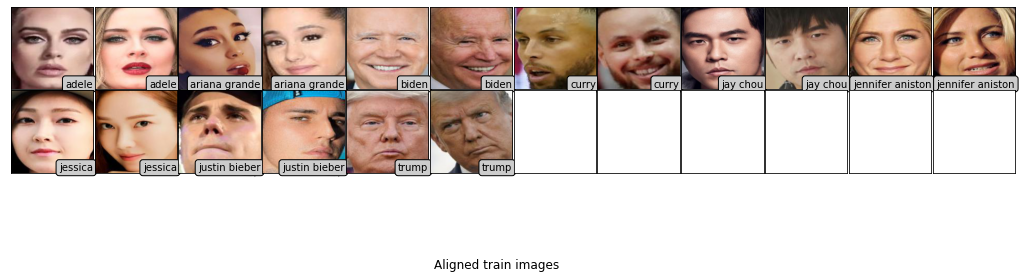

In [8]:
trainF = get_files(ALIGNED_TRAIN_DIR)
plot(paths=trainF, title='Aligned train images')

In [9]:
def fixed_denormalize(image): 
    """ Restandartize images to [0, 255]"""
    return image * 128 + 127.5

def getEmbeds(model, n, loader, imshow=False, n_img=5):
    model.eval()
    # images to display 
    images = []

    embeds, labels = [], []
    for n_i in tqdm.trange(n): 
        for i, (x, y) in enumerate(loader, 1): 

            # on each first batch get 'n_img' images  
            if imshow and i == 1: 
                inds = np.random.choice(x.size(0), min(x.size(0), n_img))
                images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

            embed = model(x.to(device))
            embed = embed.cpu().detach().numpy()
            embeds.append(embed), labels.extend(y.data.cpu().numpy())

    if imshow: 
        plot(images=np.concatenate(images))

    return np.concatenate(embeds), np.array(labels)

In [10]:
# model.eval()
# # images to display 
# images = []
# loader = trainL
# n_img=1
# embeds, labels = [], []
# for n_i in tqdm.trange(1): 
#     for i, (x, y) in enumerate(loader, 1): 

#         # on each first batch get 'n_img' images  
#         if imshow and i == 1: 
#             inds = np.random.choice(x.size(0), min(x.size(0), n_img))
#             images.append(fixed_denormalize(x[inds].data.cpu()).permute((0, 2, 3, 1)).numpy())

#         embed = model(x.to(device))
#         print(embed.shape)

100%|██████████| 50/50 [00:29<00:00,  1.70it/s]


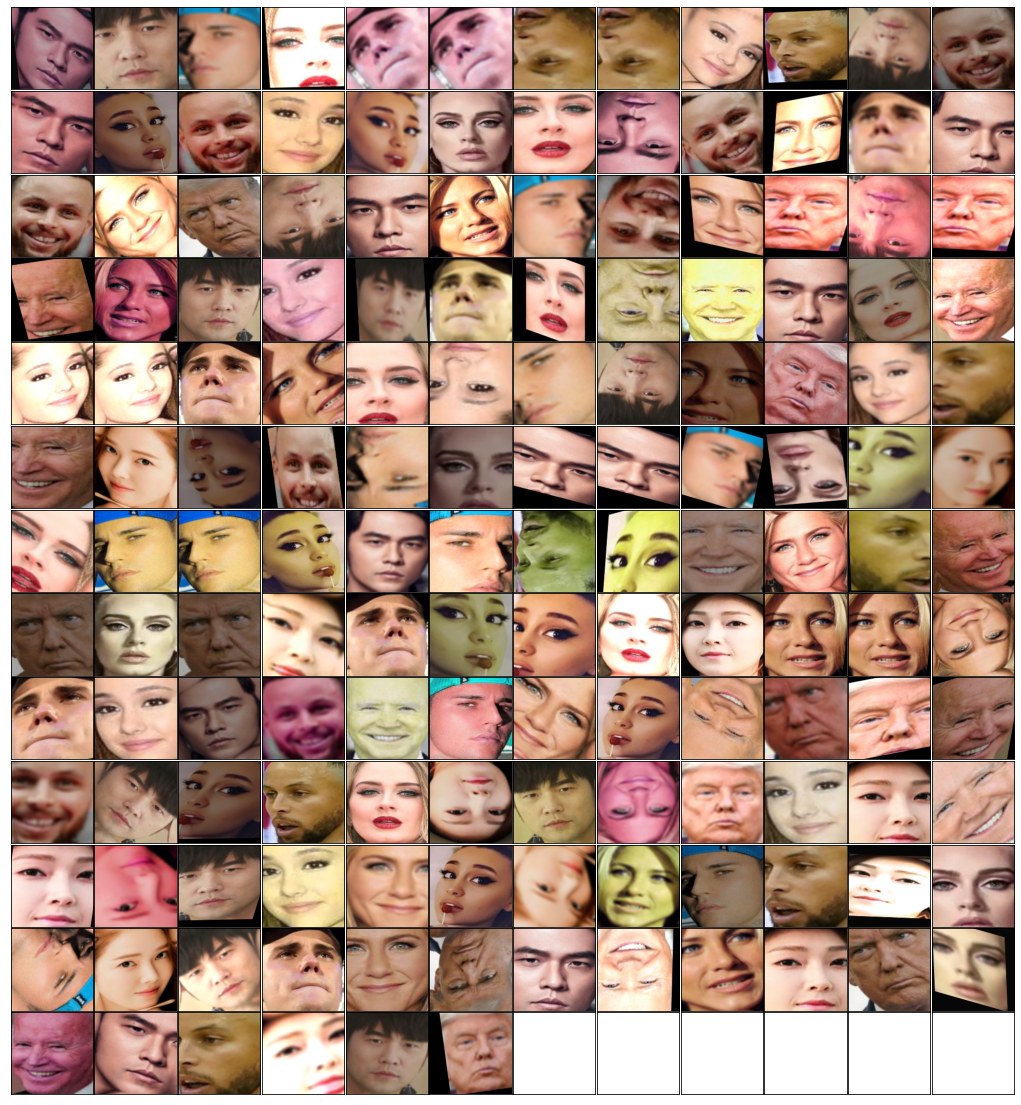

100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


In [11]:
# 3. Get embeddings 
# Train embeddings 
trainEmbeds, trainLabels = getEmbeds(model.to(device), 1, trainL, False)
trainEmbeds_aug, trainLabels_aug = getEmbeds(model.to(device), 50, trainL_aug, imshow=True, n_img=3)

trainEmbeds = np.concatenate([trainEmbeds, trainEmbeds_aug])
trainLabels = np.concatenate([trainLabels, trainLabels_aug])

# Test embeddings 
testEmbeds, testLabels = getEmbeds(model, 1, testL, False)

In [12]:
from brevitas.export import FINNManager

FINNManager.export(model.to('cpu'), input_shape=(1, 3, 160, 160), export_path="facenet.onnx")

ir_version: 7
producer_name: "pytorch"
producer_version: "1.10"
graph {
  node {
    input: "inp.1"
    input: "23"
    output: "24"
    name: "Conv_1"
    op_type: "Conv"
    attribute {
      name: "dilations"
      ints: 1
      ints: 1
      type: INTS
    }
    attribute {
      name: "group"
      i: 1
      type: INT
    }
    attribute {
      name: "kernel_shape"
      ints: 3
      ints: 3
      type: INTS
    }
    attribute {
      name: "pads"
      ints: 0
      ints: 0
      ints: 0
      ints: 0
      type: INTS
    }
    attribute {
      name: "strides"
      ints: 1
      ints: 1
      type: INTS
    }
    domain: ""
  }
  node {
    input: "24"
    input: "25"
    output: "26"
    name: "Mul_3"
    op_type: "Mul"
  }
  node {
    input: "26"
    input: "27"
    output: "28"
    name: "MultiThreshold_5"
    op_type: "MultiThreshold"
    attribute {
      name: "out_dtype"
      s: "UINT4"
      type: STRING
    }
    domain: "finn.custom_op.general"
  }
  node {
    

In [13]:
# 4. Save embeddings 
TRAIN_EMBEDS = os.path.join(DATA_PATH, 'trainEmbeds.npz')
TEST_EMBEDS = os.path.join(DATA_PATH, 'testEmbeds.npz')

np.savez(TRAIN_EMBEDS, x=trainEmbeds, y=trainLabels)
np.savez(TEST_EMBEDS, x=testEmbeds, y=testLabels)

# Load the saved embeddings to use them futher 
trainEmbeds, trainLabels = np.load(TRAIN_EMBEDS, allow_pickle=True).values()
testEmbeds, testLabels = np.load(TEST_EMBEDS, allow_pickle=True).values()

# Get named labels
trainLabels, testLabels = IDX_TO_CLASS[trainLabels], IDX_TO_CLASS[testLabels]

In [14]:
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns 
sns.set()

def getDist(x, metric='euclidean', index=None, columns=None):
    dists = pairwise_distances(x, x, metric=metric)
    return pd.DataFrame(dists, index=index, columns=columns)

def heatmap(x, title='', cmap='Greens', linewidth=1):
    plt.figure(figsize=(17, 12))
    plt.title(title)
    sns.heatmap(x, cmap=cmap, square=True)
    plt.show()

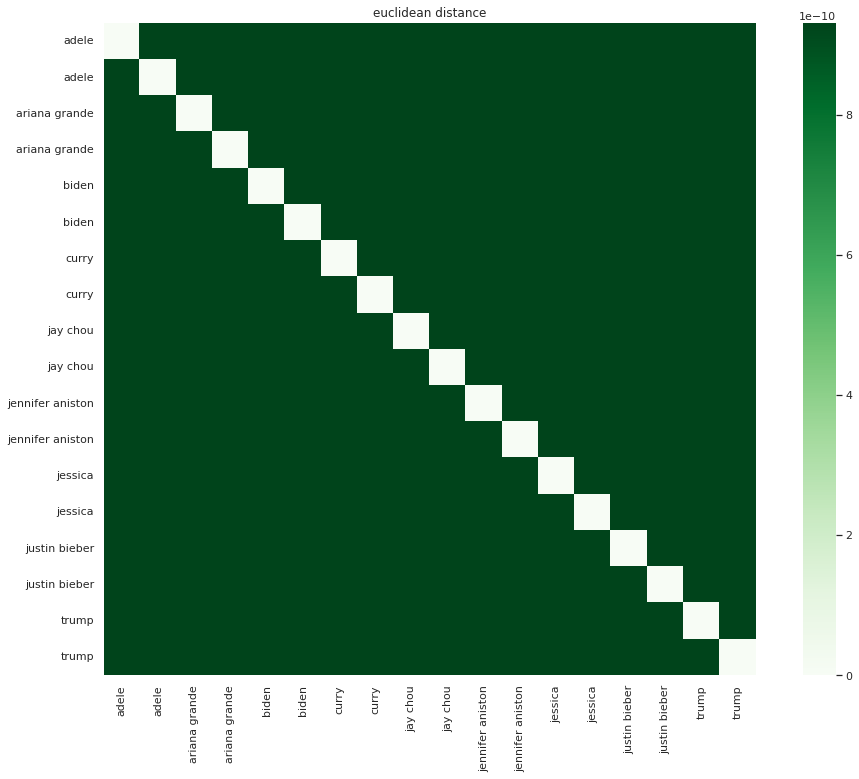

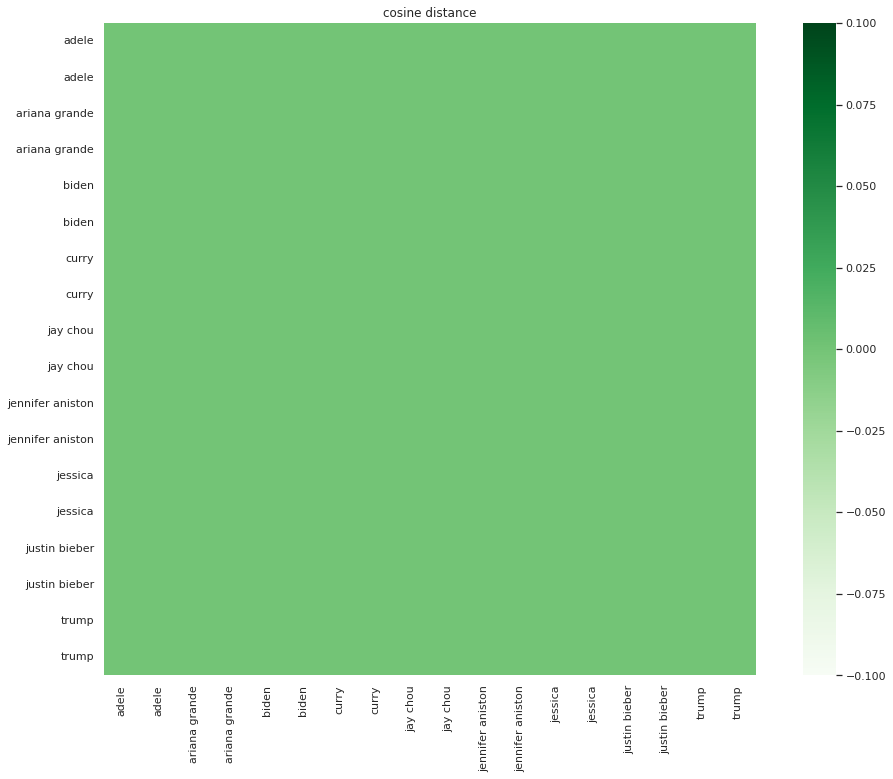

In [15]:
# Note 88 first images are original and 4247 are augmented
# as long as to calculate (4335, 512) distance matrix is time consuming we get only distances of originals 
inds = range(18)

# Train embeddings 
dists = getDist(trainEmbeds[inds], metric='euclidean', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'euclidean distance')

dists = getDist(trainEmbeds[inds], metric='cosine', index=trainLabels[inds], columns=trainLabels[inds])
heatmap(dists, 'cosine distance')

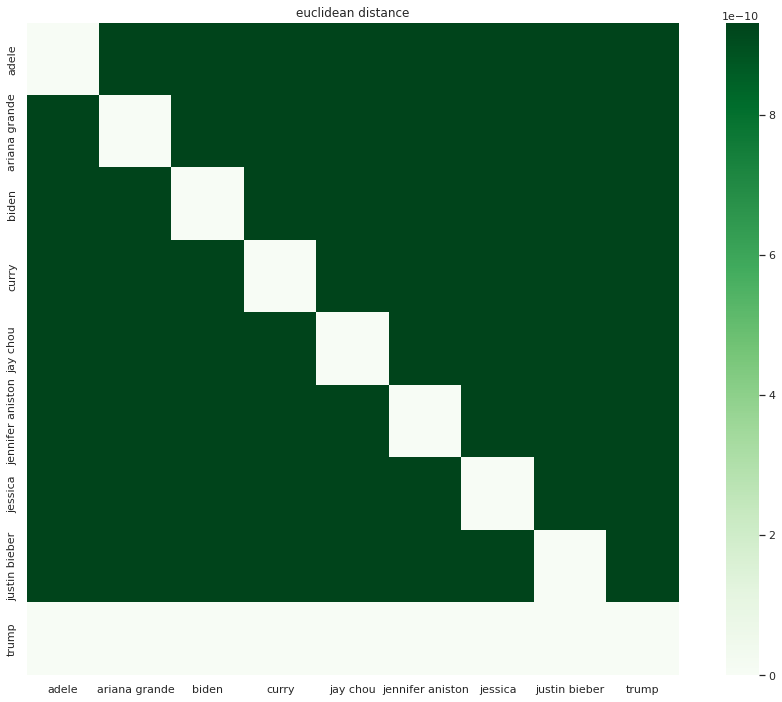

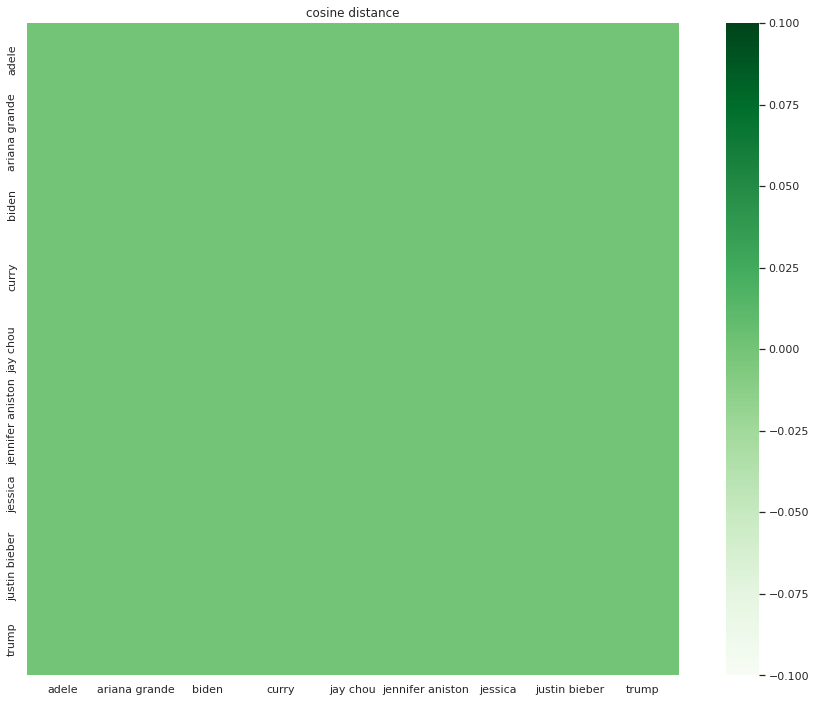

In [16]:
# Test embeddings 
dists = getDist(testEmbeds, metric='euclidean', index=testLabels, columns=testLabels)
heatmap(dists, 'euclidean distance')

dists = getDist(testEmbeds, metric='cosine', index=testLabels, columns=testLabels)
heatmap(dists, 'cosine distance')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:595: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


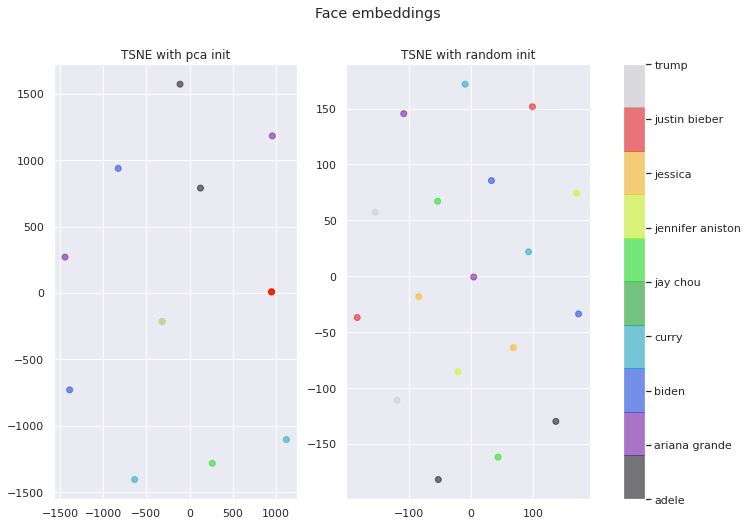

In [17]:
from sklearn.manifold import TSNE


inds = range(18)
X_tsne1 = TSNE(n_components=2, init='pca', random_state=33).fit_transform(trainEmbeds[inds])
X_tsne2 = TSNE(n_components=2, init='random', random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

img = ax[0].scatter(X_tsne1[:, 0], X_tsne1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))
ax[1].scatter(X_tsne2[:, 0], X_tsne2[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 10))

ax[0].set_title('TSNE with pca init')
ax[1].set_title('TSNE with random init')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

<class 'range'>


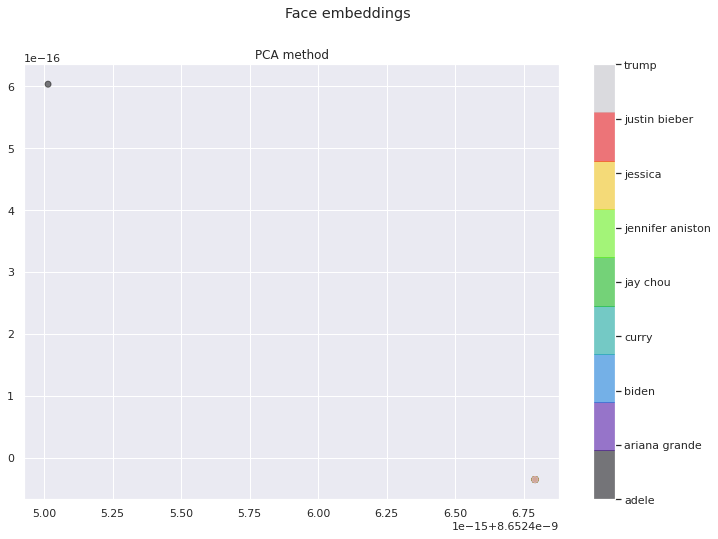

In [18]:
from sklearn.decomposition import PCA


inds = range(18)
print(type(inds))
X_pca1 = PCA(n_components=2, random_state=33).fit_transform(trainEmbeds[inds])
y = [CLASS_TO_IDX[label] for label in trainLabels[inds]]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
img = ax.scatter(X_pca1[:, 0], X_pca1[:, 1], c=y, alpha=0.5, cmap=plt.cm.get_cmap('nipy_spectral', 9))

plt.title('PCA method')
plt.suptitle('Face embeddings')

cbar = plt.colorbar(img, ax=ax)
cbar.ax.set_yticklabels(np.unique(trainLabels[inds])) 
plt.show()

In [19]:
# data preparation 
X = np.copy(trainEmbeds)
y = np.array([CLASS_TO_IDX[label] for label in trainLabels])

print(f'X train embeds size: {X.shape}')
print(f'Tagret train size: {y.shape}')

X train embeds size: (918, 9)
Tagret train size: (918,)


In [20]:
%%time 

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings

warnings.filterwarnings('ignore', 'Solver terminated early.*')

param_grid = {'C': [1, 10, 100, 1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 'auto'],
              'kernel': ['rbf', 'sigmoid', 'poly']}
model_params = {'class_weight': 'balanced', 'max_iter': 10, 'probability': True, 'random_state': 3}
model_svc = SVC(**model_params)
clf = GridSearchCV(model_svc, param_grid)
clf.fit(X, y)

print('Best estimator: ', clf.best_estimator_)
print('Best params: ', clf.best_params_)

Best estimator:  SVC(C=1, class_weight='balanced', gamma=0.0001, max_iter=10, probability=True,
    random_state=3)
Best params:  {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
CPU times: user 27.5 s, sys: 17.7 ms, total: 27.6 s
Wall time: 27.4 s


In [21]:
import joblib

SVM_PATH = os.path.join(DATA_PATH, 'svm.sav')
joblib.dump(clf, SVM_PATH)
clf = joblib.load(SVM_PATH)

In [22]:
# test data preparation 
X_test, y_test = np.copy(testEmbeds), np.array([CLASS_TO_IDX[label] for label in testLabels])
print(f'X train embeds size: {X_test.shape}')
print(f'Tagret train size: {y_test.shape}')

X train embeds size: (9, 9)
Tagret train size: (9,)


In [23]:
from sklearn.metrics import accuracy_score

inds = range(18)
train_acc = accuracy_score(clf.predict(X[inds]), y[inds])
print(f'Accuracy score on train data: {train_acc:.3f}')

test_acc = accuracy_score(clf.predict(X_test), y_test)
print(f'Accuracy score on test data: {test_acc}')

Accuracy score on train data: 0.111
Accuracy score on test data: 0.1111111111111111
